In [1]:
try:
  import google.colab

  IN_COLAB = True
  
except:
  IN_COLAB = False



In [2]:
if IN_COLAB:
    
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    from google.colab import drive

    auth.authenticate_user()
    drive.mount('/content/gdrive')

    DATA_DIR = '/content/gdrive/MyDrive/Colab Notebooks/AI@UT/M7-IntroductionToNeuralNetworks/Project/'
else:
    DATA_DIR = './'

# Project Description 



## Background and Context

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

## Objective

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.



## Data Description

The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.



## Data Dictionary 

* RowNumber: Row number. \\
* CustomerId: Unique identification key for different customers. \\
* Surname: Surname of the customer \\
* Credit Score: A credit score is a measure of an individual's ability to pay back the borrowed amount. It is the numerical representation of their creditworthiness. A credit score is a 3-digit number that falls in the range of 300-900, 900 being the highest. \\
* Geography: The country to which the customer belongs. \\
* Gender: The gender of the customer. \\
* Age: Age of the customer. \\
* Tenure: The period of time a customer has been associated with the bank. \\
* Balance: The account balance (the amount of money deposited in the bank account) of the customer. \\
* NumOfProducts: How many accounts, bank account affiliated products the person has. \\
* HasCrCard: Does the customer have a credit card through the bank? \\
* IsActiveMember: Subjective, but for the concept \\
* EstimatedSalary: Estimated salary of the customer. \\
* Exited: Did they leave the bank after all?\\

## Clarifications


# Library Imports

In [3]:
import numpy as np
from numpy.random import seed

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import plotnine
from plotnine import ggplot, geom_point, geom_line, geom_text, aes, labs, xlab, ylab, theme_classic

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.metrics import Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping


# Global Variables/Settings


In [4]:
seed(7)
tf.random.set_seed(7)

VALIDATION_SPLIT = 0.2

# Common Functions

In [5]:
def box_plot_with_info(data, column, figure_size=(18, 4)):
  '''This method creates a box plot for a specific column and shows its mean value'''

  sns.set(rc={'figure.figsize': figure_size})
  return sns.boxplot(data[column], showmeans=True)

In [6]:
def hist_plot_with_info(data, attribute, x_label, y_label, figure_size=(18, 8)):
    '''This method plots data using histogram and shows the mean, median, and mode'''
    
    mean=data[attribute].mean()
    median=data[attribute].median()
    modes=data[attribute].mode()

    print('Mean: ', mean,'\nMedian: ', median,'\n')
    print('Mode(s): ', modes)

    # Set the figure size
    plt.figure(figsize=figure_size)
    # Show data in histogram
    sns.histplot(data=data[attribute], kde=True)

    # Draw vertical lines to display mean, median, and modes
    plt.axvline(mean,color='green',label='Mean')     
    plt.axvline(median,color='blue',label='Median')
    plt.axvline(modes[0],color='red',label='Mode')

    # Add labels to the x-axis and y-axis
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    # Display the legend
    plt.legend()
    plt.show()

In [7]:
def iqr(data):
  '''This method returns the IQR of a feature'''

  return data.quantile(.75) - data.quantile(.25)
  
def lower_whisker(data):
  '''This method returns the lower whisker of a feature'''

  min = data.min()
  lower_whisker = data.quantile(.25) -  1.5 * iqr(data)

  if min < lower_whisker:
    return lower_whisker

  return min
  
def upper_whisker(data):
  '''This method returns the upper whisker of a feature'''

  max = data.max()
  upper_whisker = data.quantile(.75) +  1.5 * iqr(data)

  if max > upper_whisker:
    return upper_whisker

  return max
  
def outlier_info(data, column):
  '''This method returns two data frames that include only those observations that are outliers 
  due to a particular feature'''

  upper_outliers_df = data[data[column] > upper_whisker(data[column])]
  lower_outliers_df = data[data[column] < lower_whisker(data[column])]

  print('Upper whisker: ', upper_whisker(data[column]))
  print('Lower whisker: ', lower_whisker(data[column]))
  print('Number of upper outliers: ', upper_outliers_df[column].count())
  print('Number of lower outliers: ', lower_outliers_df[column].count())
  print('Total observations: ', data[column].count())
  print('Percentage of upper outliers: {percent:.2f}%'.format(percent=100 * upper_outliers_df[column].count() / data[column].count()))
  print('Percentage of lower outliers: {percent:.2f}%'.format(percent=100 * lower_outliers_df[column].count() / data[column].count()))

  return (upper_outliers_df, lower_outliers_df)


In [8]:
def count_uniques(data, column):
    '''This method displays the count of unique values (including the number of missing values)
    and percentages of the specified column
    '''
    
    col_series = data[column]
    col_series.fillna(value='Missing Value', inplace=True)
    
    total = len(col_series)
    p = col_series.value_counts() * 100 / total
    percentages = list("{:.2f}%".format(i) for i in p)
    unique_df = pd.DataFrame({'Count': col_series.value_counts(),
                             'Percentages': percentages})
    return unique_df

In [9]:
def feature_mean(x):
  if x.empty:
      return 0

  return x.sum() / len(x)
  
def count_exited(x):
  if x.empty:
        return 0 
    
  return x.sum()
  
def category_stats(data, feature1, feature2, column_replacements):
  '''This method displays the percentages of a feature compared to the feature total as well as the total of the dataset'''

  agg_result = data.groupby([feature1])[feature2].agg([count_exited, 'count', feature_mean])
  agg_result['total mean'] = agg_result['count_exited'] / len(data)

  agg_result.rename(columns=column_replacements, inplace=True)

  return agg_result

In [10]:
def plot_percentage_by_bin(data, continuous_column, continuous_key, target_column, target_key, bins, title='', figure_size=(18, 8)):
  '''This method first divides up continuous data into bins and creates bar plot that shows the percentage of each bin'''

  # Separate data into bins
  temp_df = data[[target_column, continuous_column]].copy()
  temp_df[continuous_key] = pd.cut(temp_df[continuous_column], bins)
  
  # Calculate the percent
  temp_df = temp_df.groupby([continuous_key, target_column]).size().unstack(fill_value=0)

  temp_df['percent'] = temp_df[target_key]/temp_df[target_key].sum()
  temp_df.reset_index(inplace=True)

  # Drop all columns except 'bin' and 'percent'
  temp_df = temp_df[[continuous_key, 'percent']]

  # Set the figure size
  plt.figure(figsize=figure_size)

  # Set the title of the figure
  plt.title(label=title)

  ax = sns.barplot(data=temp_df, x=continuous_key, y='percent')

  for patch in ax.patches:
    percent = '{:.2f}%'.format(patch.get_height() * 100)
    x = patch.get_x() + patch.get_width() / 2 - 0.02 * (len(percent) / 2)
    y = patch.get_y() + patch.get_height() / 2
    ax.annotate(percent, (x, y))

In [11]:
def create_box_labels(cm):
  '''This method creates a label for each box in a confusion matrix'''

  box_labels = [[], []]
  box_labels[0].append('TP\n{}'.format(cm[0][0]))
  box_labels[0].append('FN\n{}'.format(cm[0][1]))
  box_labels[1].append('FP\n{}'.format(cm[1][0]))
  box_labels[1].append('TN\n{}'.format(cm[1][1]))

  return box_labels

def create_cm(yTest, yPredict, model_name):
  '''This method creates a confusion matrix for a model'''

  cm = confusion_matrix(yTest, yPredict, labels=[1, 0])
  box_labels = create_box_labels(cm)

  cm_df = pd.DataFrame(cm,
                    index=["Actual 1", "Actual 0"],
                    columns=["Predicted 1", "Predicted 0"])
  plt.figure(figsize=(5, 5))

  sns.heatmap(cm_df, annot=box_labels, cmap="Blues", fmt='');
  plt.xlabel(model_name)
  plt.show()

  return cm

In [12]:
def probability_to_classification(yProb, threshold=0.5):
  '''This method converts predictions, in the form of probabilities, to predictions
  that are in the form of binary classification based on the provided threshold.'''

  yClass = np.zeros(len(yProb))
  for i in range(len(yProb)):
    if yProb[i] > threshold:
        yClass[i] = 1 
    else:
        yClass[i] = 0

  return yClass

In [13]:
def calc_model_scores(cm, modelName):
  '''This method calculates and displays model scores such as accuracy, precision, recall'''

  TP = cm[0][0]
  FN = cm[0][1]
  FP = cm[1][0]
  TN = cm[1][1]

  accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 'undefined'
  precision = TP / (TP + FP) if (TP + FP) != 0 else 'undefined'
  recall = TP / (TP + FN) if (TP + FN) != 0 else 'undefined'

  if (precision != 'undefined') and (recall != 'undefined'):
    f1 = 2 * (precision * recall) /  (precision + recall)
  else:
    f1 = 'undefined'

  scores = {'Model Name': [modelName], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1': [f1]}
  
  df = pd.DataFrame(scores)

  print(df)
  return df

In [14]:
def calc_roc_data(yTest, yPredict):
  fprValues, tprValues, thresholds = roc_curve(yTest, yPredict)

  # Calculate the G-mean
  gmean = np.sqrt(tprValues * (1 - fprValues))

  # Find the optimal threshold
  gmeanIndex = np.argmax(gmean)
  optimalThreshold = round(thresholds[gmeanIndex], ndigits = 4)
  optimalGmean = round(gmean[gmeanIndex], ndigits = 4)
  optimalFpr = round(fprValues[gmeanIndex], ndigits = 4)
  optimalTpr = round(tprValues[gmeanIndex], ndigits = 4)

  # Calculate the area under ROC curve
  auc = roc_auc_score(yTest, yPredict)

  # Create a DataFrame to hold ROC curve data
  roc_df = pd.DataFrame({'FPR':fprValues, 'TPR':tprValues, 'Threshold':thresholds})

  return roc_df, auc, optimalFpr, optimalTpr, optimalThreshold

# Reading Dataset and Feature Elimination (5 Points)



## Read the dataset properly

In [15]:
DATA_FILE = 'bank.csv'
FULL_DATA_FILE_PATH = DATA_DIR + DATA_FILE

In [16]:
print(FULL_DATA_FILE_PATH)

./bank.csv


In [17]:
bank_df = pd.read_csv(FULL_DATA_FILE_PATH)

## Print the overview of the data (statistical summary, shape, info, etc)

In [18]:
bank_df

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0          2       0.00              1          1               1   
1          1   83807.86              1          0               1   
2          8  159660.80              3          1               0   
3          1       0.00              2          0               0   
4          2  125510.82              1          1               1   
...      ...        ...            ...        ...             ...   
9995       5       0.00              2          1               0   
9996      10   57369.61              1          1               1   
9997       7       0.00              1          0               1   
9998       3   75075.31              2          1               0   
9999       4  130142.79              1          1               0   

      EstimatedSalary  Exited  
0           101348.88       1  
1           112542.58       0  
2           113931.57       1  
3            93826.63       0  
4            79084.10       0  
...               ...     ...  
9995         96270.64       0  
9996        101699.77       0  
9997         42085.58       1  
9998         92888.52       1  
9999         38190.78       0  

[10000 rows x 14 columns]

Observations:
* The dataset appears to be properly read.
* All expected columns are present. 13 independent variables and 1 target variable.
* The number of expected rows is confirmed.
* The RowNumber and CustomerId columns appear to be meaningless with respect to this analysis.

Decisions:
* Drop the RowNumber and CustomerId columns as it is not important.

In [19]:
bank_df.describe().T

count          mean           std          min  \
RowNumber        10000.0  5.000500e+03   2886.895680         1.00   
CustomerId       10000.0  1.569094e+07  71936.186123  15565701.00   
CreditScore      10000.0  6.505288e+02     96.653299       350.00   
Age              10000.0  3.892180e+01     10.487806        18.00   
Tenure           10000.0  5.012800e+00      2.892174         0.00   
Balance          10000.0  7.648589e+04  62397.405202         0.00   
NumOfProducts    10000.0  1.530200e+00      0.581654         1.00   
HasCrCard        10000.0  7.055000e-01      0.455840         0.00   
IsActiveMember   10000.0  5.151000e-01      0.499797         0.00   
EstimatedSalary  10000.0  1.000902e+05  57510.492818        11.58   
Exited           10000.0  2.037000e-01      0.402769         0.00   

                         25%           50%           75%          max  
RowNumber            2500.75  5.000500e+03  7.500250e+03     10000.00  
CustomerId       15628528.25  1.569074e+07  1.575323e+07  15815690.00  
CreditScore           584.00  6.520000e+02  7.180000e+02       850.00  
Age                    32.00  3.700000e+01  4.400000e+01        92.00  
Tenure                  3.00  5.000000e+00  7.000000e+00        10.00  
Balance                 0.00  9.719854e+04  1.276442e+05    250898.09  
NumOfProducts           1.00  1.000000e+00  2.000000e+00         4.00  
HasCrCard               0.00  1.000000e+00  1.000000e+00         1.00  
IsActiveMember          0.00  1.000000e+00  1.000000e+00         1.00  
EstimatedSalary     51002.11  1.001939e+05  1.493882e+05    199992.48  
Exited                  0.00  0.000000e+00  0.000000e+00         1.00

Observations:
* CreditScore is slightly skewed to the left.  However, its values are within valid range.
* Age is slightly skewed to te right.  However, age values are also reasonable - youngest customer is 18 and oldest is 92.
* Tenure is pretty much centered and looks normally distributed (very slightly right-skewed or no skewed).
* Balance is definitely left-skewed.  It is interesting that 25% of the customers have zero balance.  Perhaps, these may be unhappy customers and decide to more their money to a different bank.  Some outliers may also exist in this column.  But additional verification is needed.
* NumOfProducts is right-skewed
* HasCrCard is left-skewed.  About 25% of the customers do no carry the bank's credit cards.  Perhaps, these customers are unhappy with the policies, rules, and fees associated with the bank's credit cards.
* IsActiveMember indicates that 25% of the customers are not active.  It would be interesting to see the correlation between IsActiveMember and Exited.
* EstimatedSalary seems to be normally distributed (no skewness).  However, there may be outliers as the min salary is only 11.58 while the max is almost 200K.


In [20]:
bank_df.shape

(10000, 14)

Observations:
* There are 10,000 entries and 14 features.  These are consistent with the data description.

In [21]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [22]:
bank_df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [23]:
# There may be duplicate data. Check and drop if there are any.
print('Duplicates?', bank_df.duplicated().unique())

Duplicates? [False]


Observations:
* All 10,000 observations are not null
* We have 2 floating points, 9 integers and 3 objects.
* The Geography and Gender columns are categorical.  One-hot encoding needs to be applied here.  Surname can also be considered categorical, but this column may not be necessary.
* Then the features need to be converted to floating points as this data in order to create tensors from the data.
* The memory required for the data is only about 1.1MB, which is not large for conventional memory.  But if GPU is used batch processing may be necessary.
* Also, there are no duplicates in the dataset.

## Checking data for uniqueness


In [24]:
bank_df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

Observations:
* There are 10000 customers, but many have the same surname.
* The number of unique credit scores is within the number of possible scores (900 - 300 = 600)
* These customers come from only 3 countries.
* There are 2 genders as expected.
* The number of unique balance does not exceed 10000.
* HasCrCard has 2 unique values.  This is expected.
* IsActiveMember also has 2 unique values, as expected.
* All customers have unique estimated salaries, except 2.
* Exited is a binary column and it has 2 unique values as expected.

Decisions:
* RowNumber and CustomerId have unique entries for each column.  These can be dropped as they are semantically irrelevant to a customer's decision to leave the bank.

In [25]:
bank_df.drop(columns=['RowNumber', 'CustomerId'], inplace=True)
bank_df.columns

Index(['Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

# Perform an Exploratory Data Analysis on the data (5 Points)

## Univariate analysis

### Surname analysis

In [26]:
count_uniques(bank_df, 'Surname')

Count Percentages
Smith        32       0.32%
Scott        29       0.29%
Martin       29       0.29%
Walker       28       0.28%
Brown        26       0.26%
...         ...         ...
O'Kane        1       0.01%
Clapp         1       0.01%
Manners       1       0.01%
Zubareva      1       0.01%
Astorga       1       0.01%

[2932 rows x 2 columns]

Observations:
* There are almost 3000 surnames.  Smith is the most popular, followed by Scott, Martim and so forth.  But even the most popular, Smith is still only 0.32% of the total customer population.

Decisions:
* Regardless of the count and percentage of surnames, the main question about this feature is whether it contributes anything significant to the prediction or not.  It is not obvious to a human being to extract any patterns from the surname feature; therefore, I'm going to leave it as is and let the model(s) find such pattern if it exists.
* But this surname feature also causes a problem to neural network model as it is a categorical type.  Applying one-hot encoding to this feature would create almost 3000 additional features.  That requires a lot of neurons.  I've decided to use Principal Component Analysis (PCA) to reduce the number of variables, if necessary.
* A bivariate analysis on this feature and the target variable is needed to determine if this feature plays an important role in predicting customers leaving the bank or not.

### CreditScore analysis

<AxesSubplot:xlabel='CreditScore'>

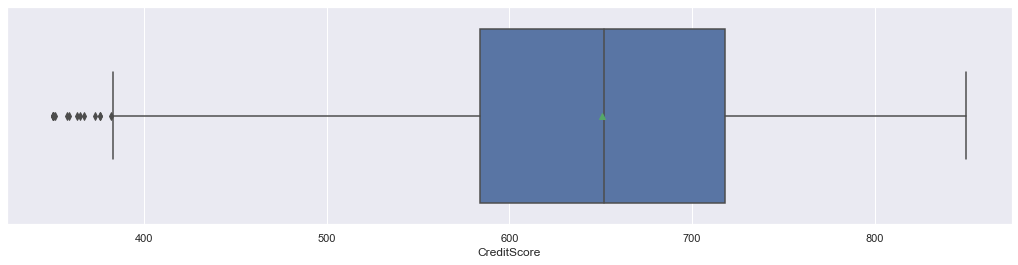

In [27]:
box_plot_with_info(bank_df, 'CreditScore')

Mean:  650.5288 
Median:  652.0 

Mode(s):  0    850
dtype: int64


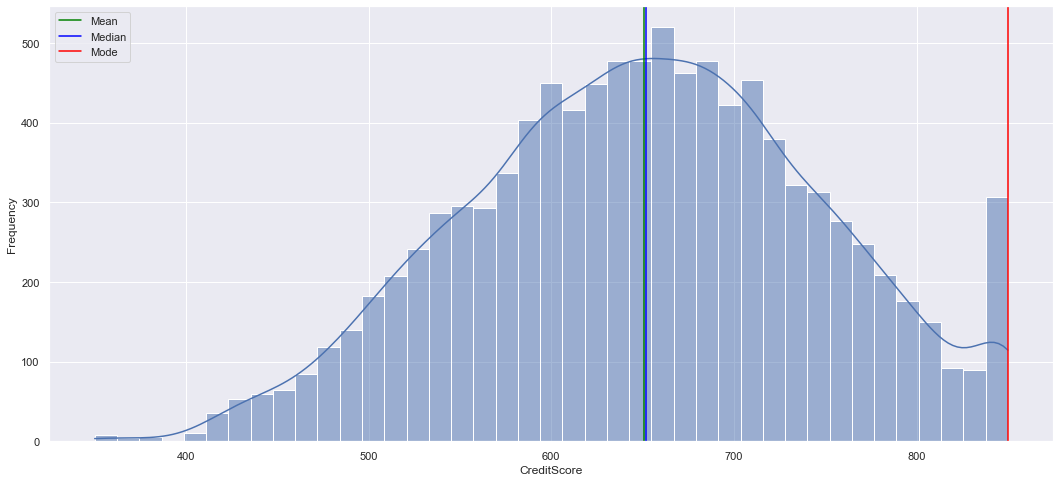

In [28]:
hist_plot_with_info(bank_df, 'CreditScore', 'CreditScore', 'Frequency')

In [29]:
cs_upper_outliers, cs_lower_outliers = outlier_info(bank_df, 'CreditScore')

Upper whisker:  850
Lower whisker:  383.0
Number of upper outliers:  0
Number of lower outliers:  15
Total observations:  10000
Percentage of upper outliers: 0.00%
Percentage of lower outliers: 0.15%


Observations:
* The credit score is almost normally distributed.  The mean and median are almost the same so the data is not skewed.  However, there is a tail on the left caused by lower outliers.  
* It's also important to recognize that the mode is on the high side.  Over 300 customers have 850 as credit scores.  These are the customers the bank sure wants to keep.  It would be interesting to know how many of these "high-valued" customers want to build their relationships with other banks.

Decisions:
* Even though there are outliers and they may make the model less accurate.  It's important to keep these outliers for a couple of reasons:
> * There are only 15 outliers based on credit scores out of 10000.
> * Unless the bank management decides to drop these "low-valued" customers, they need to be part of the model.  Otherwise, the model is not built on a dataset that represents bank customers.

### Geography analysis

In [30]:
count_uniques(bank_df, 'Geography')

Count Percentages
France    5014      50.14%
Germany   2509      25.09%
Spain     2477      24.77%

Observations:
* The customer population includes those from only 3 countries (i.e., France, Germany, and Spain).
* This feature is similar to the Surname feature as it is also categorical.  When one-hot encoding and PCA are applied, we will be able to see (hopefully) the contribution of this feature to model prediction.

Decisions:
* A bivariate analysis on this feature and the target variable will be done.  This should give us a glimpse into whether customers from one geographical region are more or less likely to leave the bank than others or not.

### Gender analysis

In [31]:
count_uniques(bank_df, 'Gender')

Count Percentages
Male     5457      54.57%
Female   4543      45.43%

Observations:
* There are more men than women within this bank's customer population.  But overall, the difference is not significant.

Decisions:
* A bivariate analysis on this feature and the target variable is also needed to determine if one gender is (un)happy more than the other about the bank's services.

### Age analysis

<AxesSubplot:xlabel='Age'>

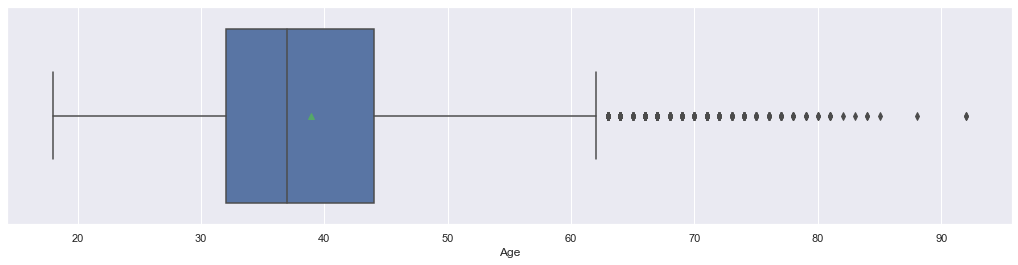

In [32]:
box_plot_with_info(bank_df, 'Age')

Mean:  38.9218 
Median:  37.0 

Mode(s):  0    37
dtype: int64


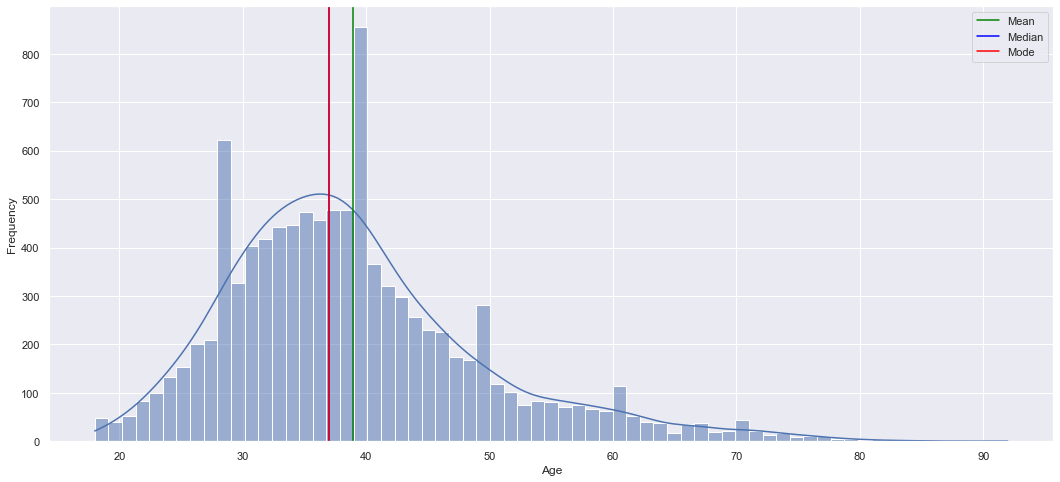

In [33]:
hist_plot_with_info(bank_df, 'Age', 'Age', 'Frequency')

In [34]:
age_upper_outliers, age_lower_outliers = outlier_info(bank_df, 'Age')

Upper whisker:  62.0
Lower whisker:  18
Number of upper outliers:  359
Number of lower outliers:  0
Total observations:  10000
Percentage of upper outliers: 3.59%
Percentage of lower outliers: 0.00%


Observations:
* The age data is skewed to the right (mean > median).
* Furthermore, with upper whisher at 62 there are quite a few outliers on the upper side.  In total, there are 359 customers whose ages are outliers compared to the rest of the bank customer population.  This represents 3.6% of the dataset.
* There are quite a few customers who are in their upper 20s or are in their low 40s.

Decisions:
* Even though there are outliers, these ages represent the norm.  Some people live in their 90s.  And as the graph shows, the higher the age the population of aged customers declines.  I don't believe it's necessary to drop these outliers because the data looks normal.
* However, it would be interesting to determine how many senior customers use the bank less.  Perhaps, they don't have as many bills compared to their younger counterparts.  Perhaps, they don't eat out or spend their money on entertainment as much.  Perhaps, they no longer have dependent children to spend their money.  These may be factors that they rely on the bank less and less.  But this may cause the bank management to think that these seniors are leaving the bank for some other bank.  A bivariate analysis will be done to gain better understanding.

### Tenure analysis

<AxesSubplot:xlabel='Tenure'>

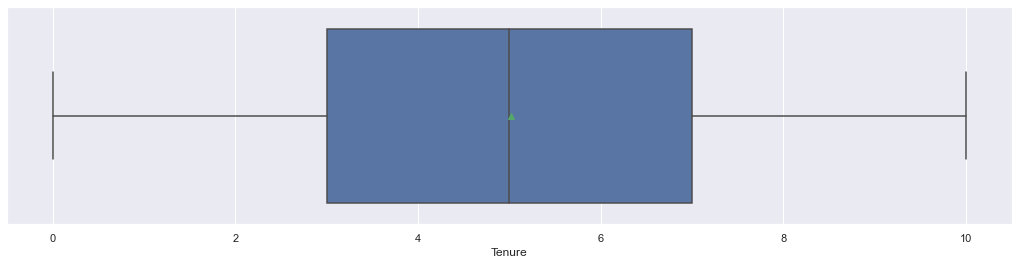

In [35]:
box_plot_with_info(bank_df, 'Tenure')

Mean:  5.0128 
Median:  5.0 

Mode(s):  0    2
dtype: int64


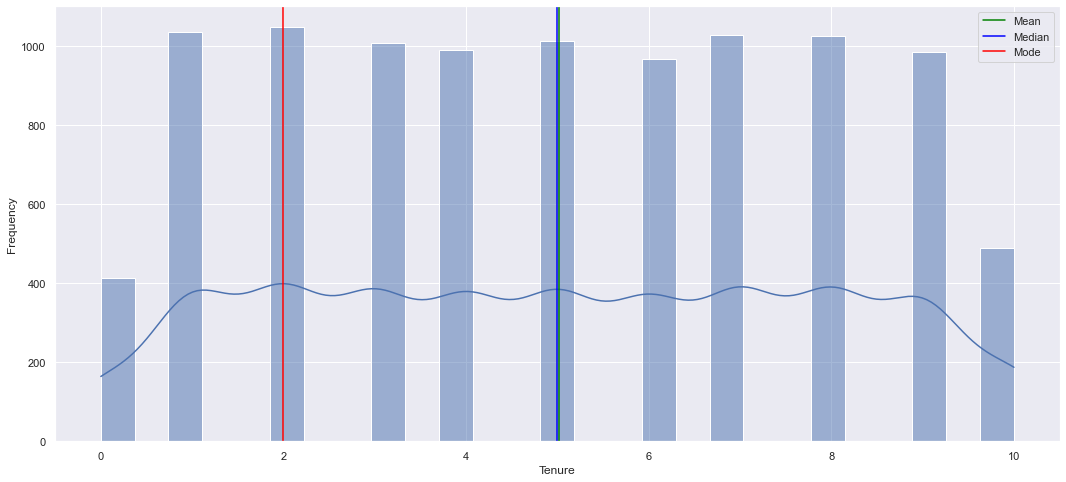

In [36]:
hist_plot_with_info(bank_df, 'Tenure', 'Tenure', 'Frequency')

Observations:
* The tenure median is right a 5.  From both plots, half of the customers have been with the bank 6-10 (days/months/years?) and the other half have less tenure.  This can have significant meaning if the unit is year.  But there is not enough information.
* There is no skewness in this variable.

Decisions:
* Discuss with bank management about the meaning of tenure.  Is it days, months, years, or something else.  If the number means something significant and if there is indication that long time customers start leaving the bank, the management team needs to take immediate action(s).
* A bivariate analysis on this feature and the target variable is necessary.

### Balance analysis

<AxesSubplot:xlabel='Balance'>

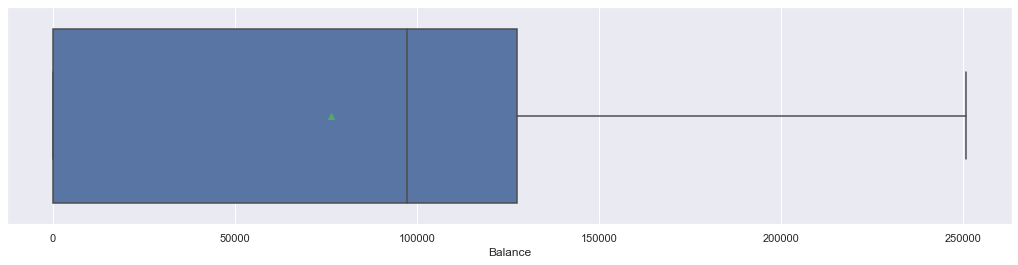

In [37]:
box_plot_with_info(bank_df, 'Balance')

Mean:  76485.889288 
Median:  97198.54000000001 

Mode(s):  0    0.0
dtype: float64


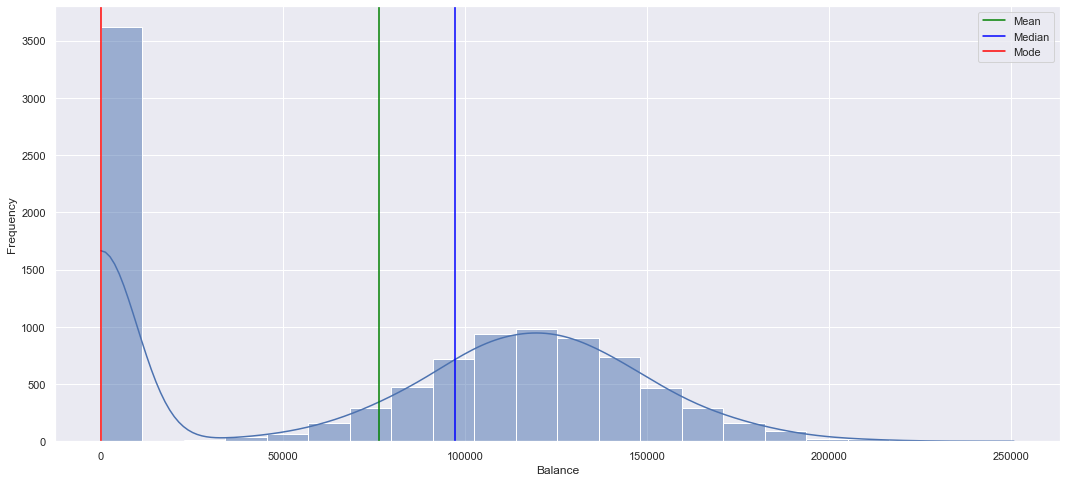

In [38]:
hist_plot_with_info(bank_df, 'Balance', 'Balance', 'Frequency')

Observations:
* This hist plot shows a nice distribution of account balance, except for the fact that more than a third of the customers have zero balance in their accounts.  This causes skewness and a second peak in the data.

Decisions:
* A bivariate analysis on this feature and the target variable is also needed.  Perhaps, the zero-balance customers have already decided to leave this bank by moving their assets to another bank's account.

### NumOfProducts analysis

In [39]:
box_plot_with_info(bank_df, 'NumOfProducts')

<AxesSubplot:xlabel='NumOfProducts'>

Mean:  1.5302 
Median:  1.0 

Mode(s):  0    1
dtype: int64


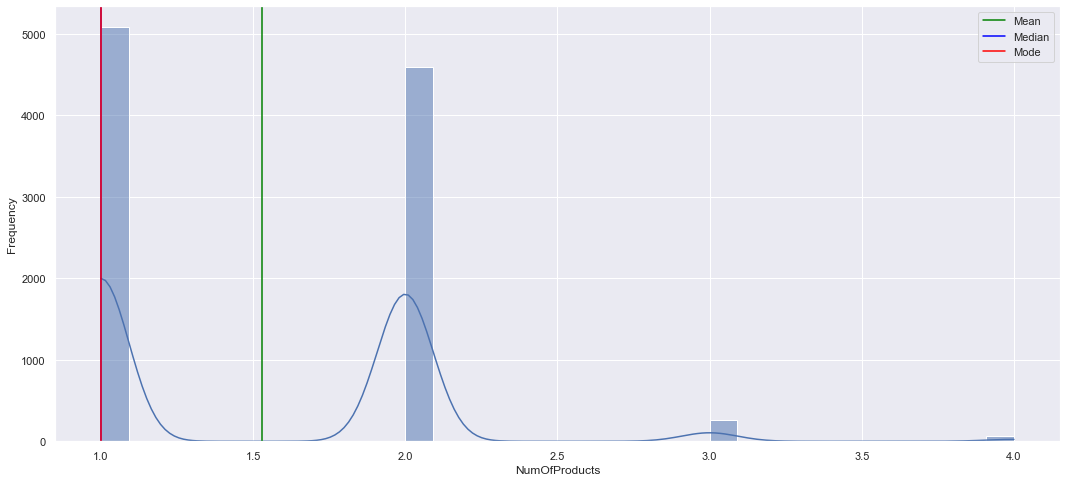

In [40]:
hist_plot_with_info(bank_df, 'NumOfProducts', 'NumOfProducts', 'Frequency')

In [41]:
nop_upper_outliers, nop_lower_outliers = outlier_info(bank_df, 'NumOfProducts')

Upper whisker:  3.5
Lower whisker:  1
Number of upper outliers:  60
Number of lower outliers:  0
Total observations:  10000
Percentage of upper outliers: 0.60%
Percentage of lower outliers: 0.00%


Observations:
* The number of products feature behaves like a discreet variable more so than a continous variable.  Therefore, a few customers who have 4 products can show up as outliers.

Decisions:
* By definitions, there are outliers.  But I don't believe they reflect anything extreme such that they shoud be dropped or treated in some way.
* Also, the number of outliers is only 0.6% of the total.  These would not affect the outcome very much.  Furthermore, when one-hot encoding is applied to this feature the outliers will be grouped as a separate feature.

### HasCrCard analysis

In [42]:
count_uniques(bank_df, 'HasCrCard')

Count Percentages
1   7055      70.55%
0   2945      29.45%

Observations:
* More than 70% of existing customers have credit cards.  It would be bad for the bank if a significant number of these customers leave because banks make a lot of money from credit card transactions.

Decisions:
* Perform a bivariate analysis on this feature ant the target variable to determine the loss in business is associated with customers who have credit card(s).

### IsActiveMember analysis

In [43]:
count_uniques(bank_df, 'IsActiveMember')

Count Percentages
1   5151      51.51%
0   4849      48.49%

Observations:
* Almost 50% of the bank customers are inactive.  This is huge.  If the lack of activities indicates that people are leaving, the bank stands a chance of losing many of its customers.

Decisions:
* Similar to other variables a bivariate analysis needs to be done for this as well.

### EstimatedSalary

<AxesSubplot:xlabel='EstimatedSalary'>

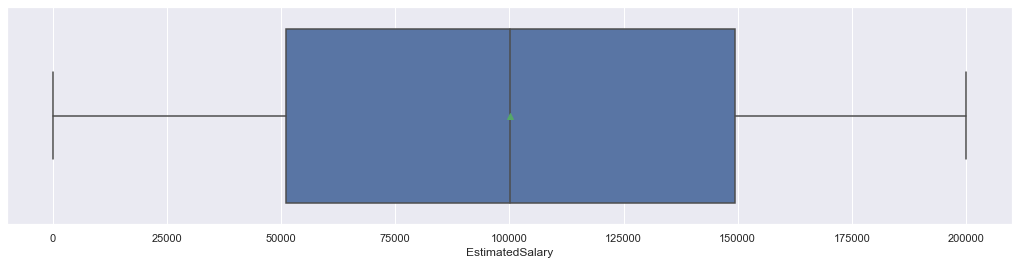

In [44]:
box_plot_with_info(bank_df, 'EstimatedSalary')

Mean:  100090.239881 
Median:  100193.915 

Mode(s):  0    24924.92
dtype: float64


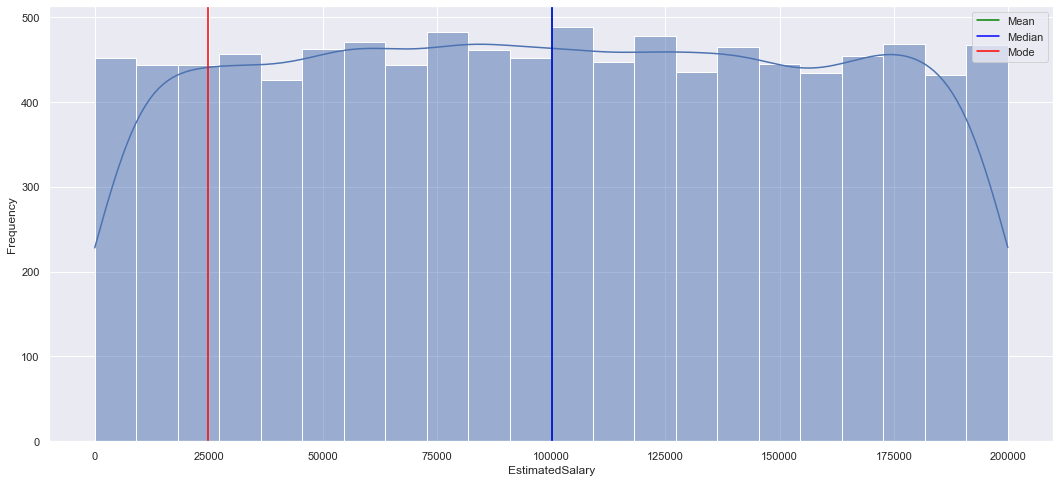

In [45]:
hist_plot_with_info(bank_df, 'EstimatedSalary', 'EstimatedSalary', 'Frequency')

Observations:
* The salary feature ranges from very low to very high.  Some numbers are particularly odd.  For example, if someone has salary of zero, one can interpret that this person does not have a job.  But if someone has a salary of 11.58, one may conclude that this individual worked for a very short period of time (less than a day) then does not work again for that year.  Or it could be concluded that there is an error in this entry.
* An interesting thing to notice is that all salary ranges are almost the same - meaning there are about the same number of people making 25,000 as there are those who make 200,000.  The data seems contrived.

Decisions:
* Without additional information or out-of-band information, it's difficult to find valid reason to drop strange data.  Therefore, I've decided to build the model with the data as is.  However, it is important to raise this issue to the bank management.  Hopefully, it can provide some clarity into the validity of the data.  The model can then be rebuilt with the updated dataset.

### Exited analysis

In [46]:
count_uniques(bank_df, 'Exited')

Count Percentages
0   7963      79.63%
1   2037      20.37%

<AxesSubplot:>

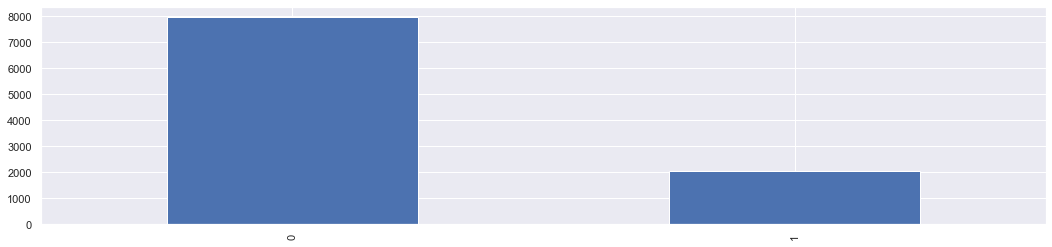

In [47]:
bank_df['Exited'].value_counts().plot.bar()

In [48]:
# Assuming no customer leaves the bank
guess_cm = [[0, 2037], [0, 7963]]

# Compute the scores of this ignorant model
ignorant_model_scores_df = calc_model_scores(guess_cm, 'Ignorant Model')
ignorant_model_scores_df

       Model Name  Accuracy  Precision  Recall         F1
0  Ignorant Model    0.7963  undefined     0.0  undefined


Model Name  Accuracy  Precision  Recall         F1
0  Ignorant Model    0.7963  undefined     0.0  undefined

Observations:
* The bank has lost 20% of its customers.  But based on the number of customers with zero balance and those who are inactive, the bank may lose even more customers.
* If one completely guesses at this question "Does this customer leave the bank?" for every customer by answering "no," this person would be wrong 20.37% of the time or wrong on 2037 of the customers.  This would translate to the metrics above (accuracy = 0.7963 and recall = 0.0).  Any model built in the sections below must perform better than this ignorant strategy.

## Bivariate analysis

#### Surname vs. Exited

In [49]:
# Create subset of data for bivariate analysis
temp_df = bank_df[['Surname', 'Exited']].copy()
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Surname  10000 non-null  object
 1   Exited   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [50]:
surname_exited_df = temp_df[temp_df['Exited'] == 1]
print('Number of exited customers: ', surname_exited_df.shape[0])

Number of exited customers:  2037


In [51]:
print('Number of duplicates: ', len(surname_exited_df.duplicated()))

Number of duplicates:  2037


Observations:
* There are 2037 exited customers.  Each of them has a unique surname.  So there isn't a common pattern by surname.

Decisions:
* Based on that observation, I believe the Surname feature can be dropped.  And therefore, PCA is not necessary to reduce the number of features, due to the number of surnames.

In [52]:
# Drop Surname feature from dataset
bank_df.drop(columns=['Surname'], inplace=True)
bank_df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

#### CreditScore vs Exited

In [53]:
# Create subset of data for bivariate analysis
creditscore_exited_df = bank_df[['CreditScore', 'Exited']].copy()
creditscore_exited_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   CreditScore  10000 non-null  int64
 1   Exited       10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


In [54]:
creditscore_exited_df.groupby('Exited').describe()

CreditScore                                                           
             count        mean         std    min    25%    50%    75%    max
Exited                                                                       
0           7963.0  651.853196   95.653837  405.0  585.0  653.0  718.0  850.0
1           2037.0  645.351497  100.321503  350.0  578.0  646.0  716.0  850.0

In [55]:
min = np.floor(creditscore_exited_df['CreditScore'].min()).astype(int)
max = np.ceil(creditscore_exited_df['CreditScore'].max()).astype(int)
increment = round((max - min) / 10)
bins = list(range(min, max + increment, increment))
bins

[350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850]

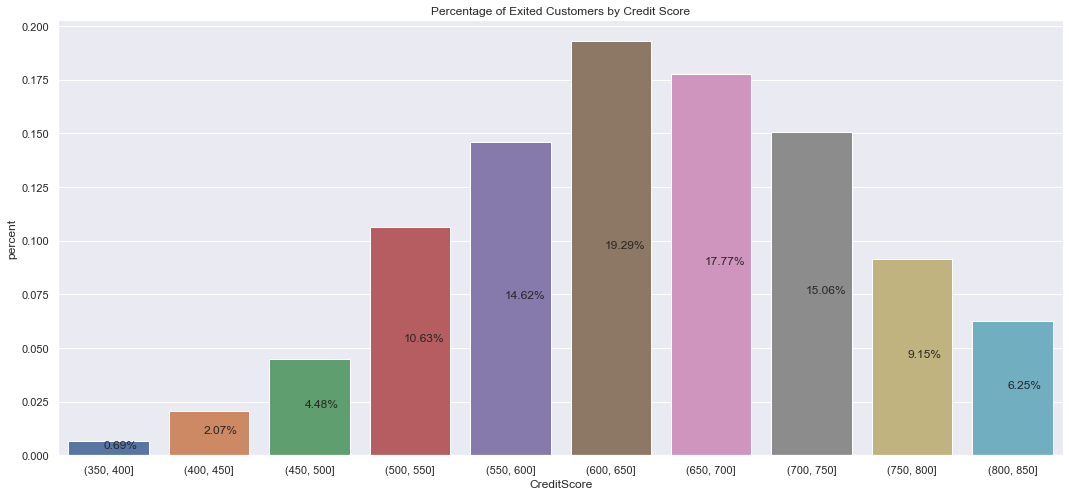

In [56]:
title = 'Percentage of Exited Customers by Credit Score'
plot_percentage_by_bin(creditscore_exited_df, 'CreditScore', 'CreditScore', 'Exited', 1, bins, title)

Observations:
* Based on this analysis those who left the bank has a lower credit score on average (646 vs. 653).  But this is not a strong indication as the difference between the means is only about 6 points.
* The credit scores of the customers who leave the bank create an almost normally distributed curve.  This means there is no linear relationship between these 2 variables.  Therefore, we cannot conclude that the people who leave the bank are not from a specific group (i.e, customers who left the bank have credit scores in the range of 500-550).  But it is evident that those whose scores are in the mid range (500-750) leave in higher percentage than other groups.

#### Geography vs. Exited

In [57]:
# Create subset of data for bivariate analysis
geography_exited_df = bank_df[['Geography', 'Exited']].copy()
geography_exited_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Geography  10000 non-null  object
 1   Exited     10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [58]:
column_replacements = {'count_exited':'Num Exited', 'count':'Count', 'feature_mean':'Geographical Mean', 'total mean':'Total Mean'}
category_stats(geography_exited_df, 'Geography', 'Exited', column_replacements)

Num Exited  Count  Geographical Mean  Total Mean
Geography                                                  
France            810   5014           0.161548      0.0810
Germany           814   2509           0.324432      0.0814
Spain             413   2477           0.166734      0.0413

Definitions:
* There are 2 types of mean, "geographical" mean and "total" mean.  Geographical mean is the mean computed relative to the number of customers from a single country (e.g., France).  The total mean is the mean computed relative to the number of customers of the bank.

Observations:
* Customers from France make up half of the customer population (5014).  Customers from Germany (2509) and Spain (2477) roughly split the other half.
* More customers from Germany (814) leave the bank than those from France (810) or Spain (413) by count.
* While the total means of german customers (8.14%) and french customers (8.1%) are about the same, the geographical mean for these two groups are quite different.
* The rate of german customers leaving the bank (32.44%) is twice as much higher compared to that of the french customers (16.15%) or spanish customers (16.67%).  The geographical means are used here.

#### Gender vs Exited

In [59]:
gender_exited_df = bank_df[['Gender', 'Exited']].copy()
gender_exited_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  10000 non-null  object
 1   Exited  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [60]:
column_replacements = {'count_exited':'Num Exited', 'count':'Count', 'feature_mean':'Gender Mean', 'total mean':'Total Mean'}
category_stats(gender_exited_df, 'Gender', 'Exited', column_replacements)

Num Exited  Count  Gender Mean  Total Mean
Gender                                            
Female        1139   4543     0.250715      0.1139
Male           898   5457     0.164559      0.0898

Observations:
* The female customers make up less than half of the customer population.  But more female customers leave the bank than their male counterpart, based on gender mean.
* The "total" mean of female customers (11.39%) leaving the bank is only 2% higher than that of the male customers.  But within-gender analysis it shows that female customers are 9% (25.0% - 16.4%) more likely to leave the bank.

#### Age vs Exited

In [61]:
# Create subset of data for bivariate analysis
age_exited_df = bank_df[['Age', 'Exited']].copy()
age_exited_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Age     10000 non-null  int64
 1   Exited  10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


In [62]:
bins = list(range(0, 100, 10))
bins

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

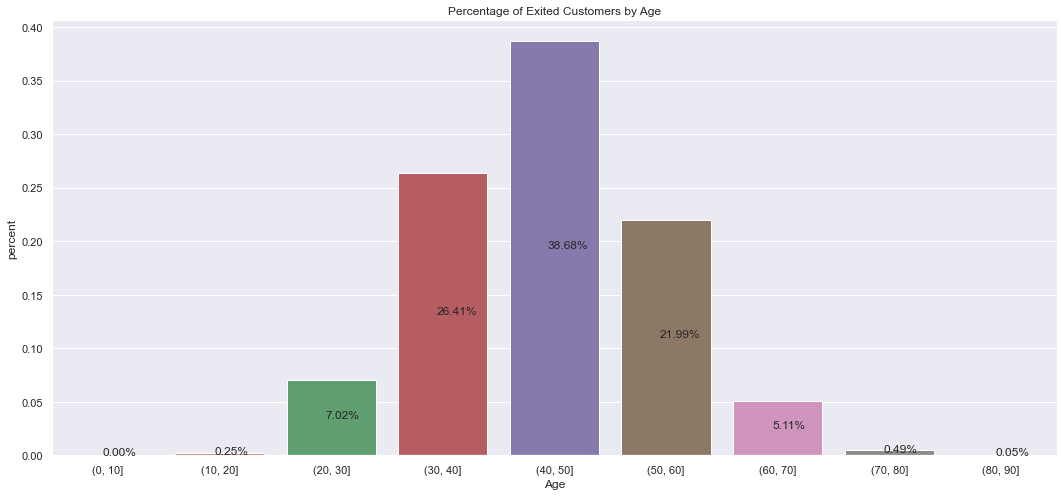

In [63]:
title = 'Percentage of Exited Customers by Age'
plot_percentage_by_bin(age_exited_df, 'Age', 'Age', 'Exited', 1, bins, title)

Observations:
* The bar graph above shows the percentage of customers leaving the bank by age group.
* Of the customers leaving the bank, people in age group >40-50 make up 38.68%.  Customers who are >30-40 years old make up the second largest group, followed by those who are >50-60 years old.  These are the age groups that are more likely to perform many transactions because they are likely to have more bills and expenses than their younger or older counterparts.

#### Tenure vs. Exited

In [64]:
# Create subset of data for bivariate analysis
tenure_exited_df = bank_df[['Tenure', 'Exited']].copy()
tenure_exited_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Tenure  10000 non-null  int64
 1   Exited  10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


In [65]:
bins = list(sorted(tenure_exited_df['Tenure'].unique()))
bins

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

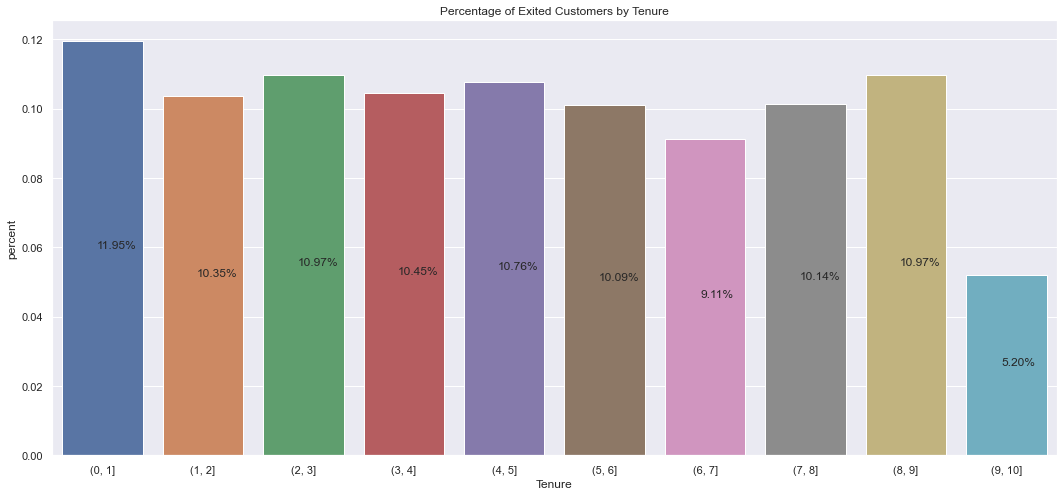

In [66]:
title = 'Percentage of Exited Customers by Tenure'
plot_percentage_by_bin(tenure_exited_df, 'Tenure', 'Tenure', 'Exited', 1, bins, title)

Observations:
* Except for those customers who have been with the bank 9+ (years?), the tenure feature does not really provide a good indicator which customer would likely to leave the bank.

#### Balance vs. Exited

In [67]:
# Create subset of data for bivariate analysis
balance_exited_df = bank_df[['Balance', 'Exited']].copy()
balance_exited_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Balance  10000 non-null  float64
 1   Exited   10000 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 156.4 KB


In [68]:
min = np.floor(balance_exited_df['Balance'].min()).astype(int)
max = np.ceil(balance_exited_df['Balance'].max()).astype(int)
increment = round((max - min) / 10000) * 1000
bins = list(range(min, max, increment))
bins

[0,
 25000,
 50000,
 75000,
 100000,
 125000,
 150000,
 175000,
 200000,
 225000,
 250000]

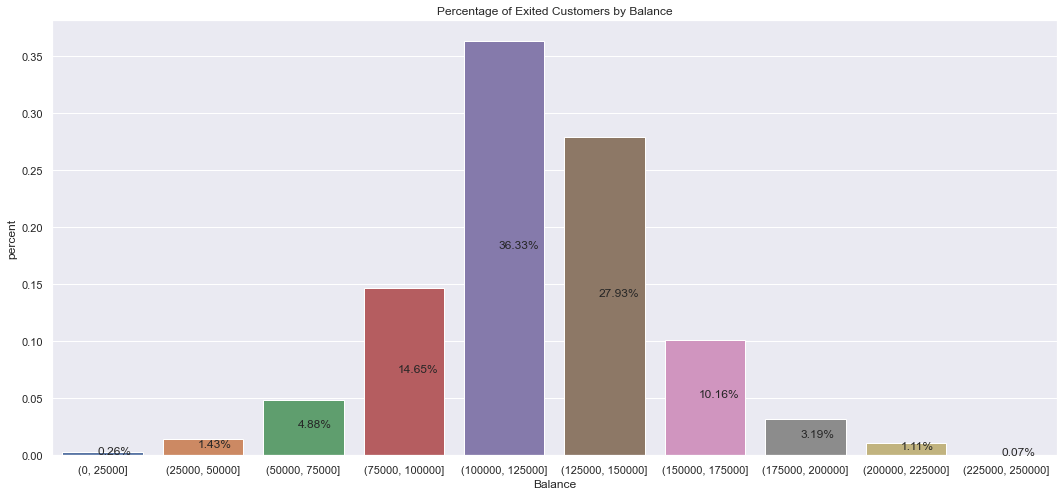

In [69]:
title = 'Percentage of Exited Customers by Balance'
plot_percentage_by_bin(balance_exited_df, 'Balance', 'Balance', 'Exited', 1, bins, title)

Observations:
* Of the customers who leave the bank, the largest 5 groups (from 50,000-175,000) make up more 90%.  These groups include those customers who have significant amount in their accounts.
* Contrary to my earlier analysis, the people who have little in their accounts are not leaving as previously thought.

#### NumOfProducts vs. Exited

In [70]:
# Create subset of data for bivariate analysis
numofproducts_exited_df = bank_df[['NumOfProducts', 'Exited']].copy()
numofproducts_exited_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   NumOfProducts  10000 non-null  int64
 1   Exited         10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


In [71]:
bins = list(sorted(numofproducts_exited_df['NumOfProducts'].unique()))
bins

[1, 2, 3, 4]

In [72]:
title = 'Percentage of Exited Customer by Number of Products'
plot_percentage_by_bin(numofproducts_exited_df, 'NumOfProducts', 'NumOfProducts', 'Exited', 1, bins, title)

Observations:
* Customers who use the least number of products from the bank are more likely to leave the bank.

#### HasCrCard vs. Exited

In [73]:
# Create subset of data for bivariate analysis
hascrcard_exited_df = bank_df[['HasCrCard', 'Exited']].copy()
hascrcard_exited_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   HasCrCard  10000 non-null  int64
 1   Exited     10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


In [74]:
column_replacements = {'count_exited':'Num Exited', 'count':'Count', 'feature_mean':'Has-Credit-Card Mean', 'total mean':'Total Mean'}
category_stats(hascrcard_exited_df, 'HasCrCard', 'Exited', column_replacements)

Num Exited  Count  Has-Credit-Card Mean  Total Mean
HasCrCard                                                     
0                 613   2945              0.208149      0.0613
1                1424   7055              0.201843      0.1424

Observations:
* Customers who have a credit credit, 20.1% leave the bank.  This is similar to those who do not have a credit card (20.8%).
* But using the total populate as the basis, those who have a credit card are more likely to leave the bank (8% more).

#### IsActiveMember vs. Exited

In [75]:
# Create subset of data for bivariate analysis
isactivemember_exited_df = bank_df[['IsActiveMember', 'Exited']].copy()
isactivemember_exited_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   IsActiveMember  10000 non-null  int64
 1   Exited          10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


In [76]:
column_replacements = {'count_exited':'Num Exited', 'count':'Count', 'feature_mean':'Is-Active-Member Mean', 'total mean':'Total Mean'}
category_stats(isactivemember_exited_df, 'IsActiveMember', 'Exited', column_replacements)

Num Exited  Count  Is-Active-Member Mean  Total Mean
IsActiveMember                                                      
0                     1302   4849               0.268509      0.1302
1                      735   5151               0.142691      0.0735

Observations:
* The customer population includes active and inactive members.  Each makes up about half of the customer population.
* However, those who are inactive are more likely to leave.
* Within the inactive group, 26.8% leave the bank wheras 14.2% leave the bank among active members.
* When compared to the total customer population, inactive members who leave the bank make up 13%, while active members make up 7.3%.

#### EstimatedSalary vs. Exited

In [77]:
# Create subset of data for bivariate analysis
estimatedsalary_exited_df = bank_df[['EstimatedSalary', 'Exited']].copy()
estimatedsalary_exited_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   EstimatedSalary  10000 non-null  float64
 1   Exited           10000 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 156.4 KB


In [78]:
min = 0
max = round(estimatedsalary_exited_df['EstimatedSalary'].max() / 10000) * 10000
increment = round((max - min) / 10000) * 1000
bins = list(range(min, max, increment))
bins

[0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000]

In [79]:
title = 'Percentage of Exited Customers by Estimated Salary'
plot_percentage_by_bin(estimatedsalary_exited_df, 'EstimatedSalary', 'EstimatedSalary', 'Exited', 1, bins, title)

Observations:
* EstimatedSalary feature does not seem to play a role in the prediction of which customers leave the bank.

## Use appropriate visualizations to identify the patterns and insights

In [80]:
def highlight_data(cell):
  '''This method highlights cells that have values higher certain thresholds'''

  color = ''
  if cell > 10:
    color = 'red'
  elif cell > 8:
    color = 'orange'

  return 'background-color: % s' % color

In [81]:
table = pd.pivot_table(bank_df, 
                             index = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'], 
                             values = 'Exited', 
                             aggfunc = 'sum')

# Calculating percentage of exited customers within each group
PERCENT_EXITED = '% Exited'
EXITED = 'Exited'
table[PERCENT_EXITED] = (table[EXITED]/table[EXITED].sum())*100
display(table.style.applymap(highlight_data,
                             subset = pd.IndexSlice[:, [PERCENT_EXITED]]))


## Come up with a customer profile (characteristics of a customer) of the different packages 
Definitions:
* Customer segments are groups of customers that are defined by geography, gender, has credit card, and is active member.  These are the categorical variables.
* These segments can also be defined using the continous variables (e.g., CreditScore, Age, etc.), using bins.  However, coupling the number of bins and the categorical groups would make the data overwhelming and hard to read.

Profiles of Exited Customers:
* There is no one profile that can describe all exited customers.  Below are profiles of the customer segments that are more likely to leave the bank.
> 1. Customers who are french females, who carry a credit card and is inactive are mostly likely to leave.
> 2. Customers who are german females, who carry a credit card and is inactive are the second most likely to leave.
> 3. Customers who are german males, who carry a credit card and is inactive are the third most likely to leave.
> 4. Customers who are french males, who carry a credit card and is inactive are the fourth most likely to leave.

Profile Summary:
* Combining those 4 statements above, one can conclude that customers who are either french or german, carry a credit card and are inactive are likely to leave.
* Coupled with credit score >500 and <750, age >30 and <60, balance >50K and <175K, a customer is even more likely to leave.


## Any other exploratory deep dive

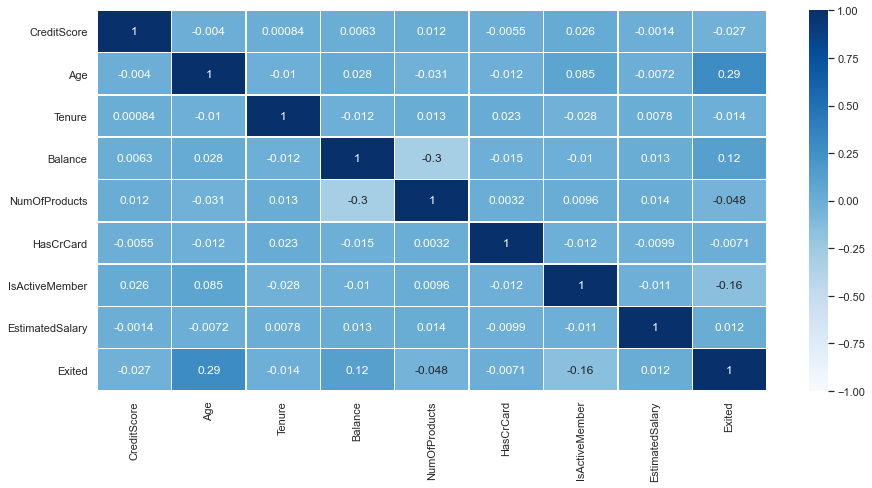

In [82]:
plt.figure(figsize=(15,7))
sns.heatmap(bank_df.corr(), annot=True, linewidths=0.5, vmin=-1, vmax=1, center=0, cmap='Blues')
plt.show()

Observations:
* Age shows the highest correlation, but this is still low.
* The continuous variables do not show strong correlation with the target variable.  This is because the relationship between these variables and the target variable is not linear.  This is easily seen in the graphs in the Bivariate analysis sub-sections.


# Illustrate the insights based on EDA (5 Points)

## Key meaningful observations from Bivariate analysis
* Please see observations throughout Bivariate analysis and description of customer profile(s) of those who are likely to leave the bank above.

# Data Pre-processing (10 Points)

In [83]:
# Convert all categorical data using one-hot encoding and change the type to floating point
bank_float_df = pd.get_dummies(bank_df)
bank_float_df = bank_float_df.astype('float32')


## Split the target variable and predictors

In [84]:
# Display all columns to ensure correct splitting of independent and dependent variables
bank_float_df.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'],
      dtype='object')

In [85]:
# Assign X_data to all independent variables
X_data = bank_float_df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']]
num_features = X_data.shape[1]

# Assign y_data to the target variable
y_data = bank_float_df['Exited']

In [86]:
# Check the shape of the data
print('Shape of X_data: ', X_data.shape)
print('Shape of y_data: ', y_data.shape)

Shape of X_data:  (10000, 13)
Shape of y_data:  (10000,)


In [87]:
# Cursory verify the independent features
X_data.head()

CreditScore   Age  Tenure        Balance  NumOfProducts  HasCrCard  \
0        619.0  42.0     2.0       0.000000            1.0        1.0   
1        608.0  41.0     1.0   83807.859375            1.0        0.0   
2        502.0  42.0     8.0  159660.796875            3.0        1.0   
3        699.0  39.0     1.0       0.000000            2.0        0.0   
4        850.0  43.0     2.0  125510.820312            1.0        1.0   

   IsActiveMember  EstimatedSalary  Geography_France  Geography_Germany  \
0             1.0    101348.882812               1.0                0.0   
1             1.0    112542.578125               0.0                0.0   
2             0.0    113931.570312               1.0                0.0   
3             0.0     93826.632812               1.0                0.0   
4             1.0     79084.101562               0.0                0.0   

   Geography_Spain  Gender_Female  Gender_Male  
0              0.0            1.0          0.0  
1              1.0            1.0          0.0  
2              0.0            1.0          0.0  
3              0.0            1.0          0.0  
4              1.0            1.0          0.0

In [88]:
# Cursory verify the target variable
y_data.head()

0    1.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: Exited, dtype: float32

## Split the data into train, validation, and test

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3, stratify=y_data, random_state = 7)

## Rescale the data

In [90]:
scaler = StandardScaler()

# Fit the scaler with train data
scaler.fit(X_train)

# Then transform train, validation and test data using the same scale to avoid data leakage
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [91]:
X_train

array([[-0.27062893, -1.4336517 , -0.00921668, ..., -0.58196914,
         1.0985488 , -1.0985488 ],
       [-0.37411764, -0.5748919 , -0.6992353 , ..., -0.58196914,
        -0.9102918 ,  0.9102918 ],
       [ 0.1329771 , -0.9565629 ,  1.7158298 , ..., -0.58196914,
         1.0985488 , -1.0985488 ],
       ...,
       [-0.03260486, -0.5748919 , -1.0442446 , ..., -0.58196914,
         1.0985488 , -1.0985488 ],
       [-0.63283944, -1.7199049 ,  1.0258112 , ..., -0.58196914,
         1.0985488 , -1.0985488 ],
       [-0.98470116,  0.09303231, -0.354226  , ..., -0.58196914,
        -0.9102918 ,  0.9102918 ]], dtype=float32)

In [92]:
X_test

array([[ 0.85739815, -1.2428161 ,  0.6808019 , ..., -0.58196914,
        -0.9102918 ,  0.9102918 ],
       [ 1.354144  , -0.5748919 ,  0.33579263, ...,  1.7183042 ,
         1.0985488 , -1.0985488 ],
       [-0.3844665 , -0.09780319, -1.3892539 , ..., -0.58196914,
         1.0985488 , -1.0985488 ],
       ...,
       [-1.4297026 ,  3.4326534 ,  1.3708205 , ..., -0.58196914,
         1.0985488 , -1.0985488 ],
       [-0.5396996 , -1.0519806 , -1.0442446 , ..., -0.58196914,
        -0.9102918 ,  0.9102918 ],
       [ 1.4990282 ,  1.6197163 ,  1.3708205 , ..., -0.58196914,
        -0.9102918 ,  0.9102918 ]], dtype=float32)

# Model building (10 Points)

## Build Neural Network

### Model 1 - Simple Neural Network
* The goal of this model is to include 1 input layer, 2 hidden layers, and 1 output layer.
* In terms of optimization, the Adam optimizer will be used with default learning rate

In [93]:
# Create a Sequential model
model_1 = Sequential()
model_name = 'M1-Simple Neural Network'

In [94]:
# Add an input layer and the first hidden layer
model_1.add(Dense(units=24, input_dim=num_features, activation='relu'))

# Add more hidden layer
model_1.add(Dense(units=24, activation='relu'))

# Add the output layer
model_1.add(Dense(1, activation='sigmoid'))

In [95]:
# Compile the model with an optimizer and a loss function
model_1.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=[Recall()])

In [96]:
# Verify the model - it should be consistent with the added layers
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [97]:
# Train the model with train data
history = model_1.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=VALIDATION_SPLIT, verbose=0)

Text(0.5, 0, 'M1-Simple Neural Network')

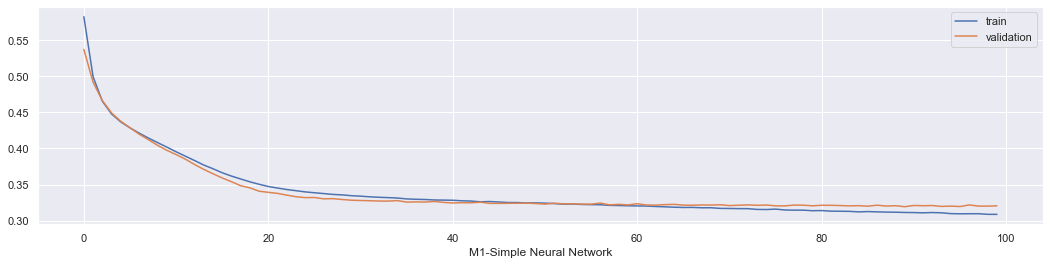

In [98]:
# Create a data frame for history to plot
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch

# Plot the loss of the model vs. epoch
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.legend(("train", "validation"), loc='best')
plt.xlabel(model_name)

In [99]:
# Evaluate the model against test data
score = model_1.evaluate(X_test, y_test)

94/94 [==============================] - 0s 486us/step - loss: 0.3600 - recall: 0.4845


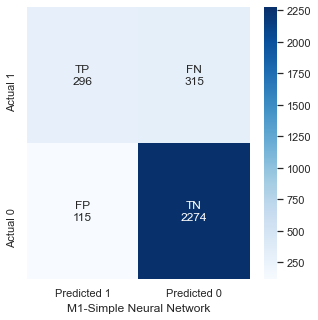

                 Model Name  Accuracy  Precision    Recall        F1
0  M1-Simple Neural Network  0.856667   0.720195  0.484452  0.579256


Model Name  Accuracy  Precision    Recall        F1
0  M1-Simple Neural Network  0.856667   0.720195  0.484452  0.579256

In [100]:
# Use the model to predict the probabilities
y_prob_predict = model_1.predict(X_test)

# Convert probabilities to classification
y_class_predict = probability_to_classification(y_prob_predict)

# Create confusion matrix
cm = create_cm(y_test, y_class_predict, model_name)

# Calculate the scores of this model
model_1_scores_df = calc_model_scores(cm, model_name)
model_1_scores_df

Observations:

* Almost 80% of the dataset are customers who are not leaving.  Without building any model one can be about 80% accurate at guessing.
* The model above is slightly better, given the fact that it is 85.5% accurate.
* But these scores are not good enough - they need to be improved.

Decisions:
* Various models will be built (below) in an attempt to improve these scores.  This model (Model 1) will be initially used as the basis to build other models by varying different parameters.  Those models that are better than Model 1 will be kept, while those with worse scores will be discarded.  Through this process, I hope to be able to explain which parameters make the difference(s) in model improvement.


#### Comment on which metric is right for model performance evaluation and why?

* Accuracy is probably a favorite choice for model performance evaluation.  If accuracy is high (close to 1), it means the false positive and false negative would be low (close to 0).  But to achieve 100% accuracy is unlikely, precision and recall must also be carefully considered.  And this depends on what we try to achieve from an analysis.
* In this case the bank wants to prevent losing customers because customer loss means profit decline and potentially business loss.  Predicting a customer not leaving when (s)he is actually leaving would be a bad prediction.  Therefore, the false negatives need to go down and true positives need to go up.  In other words, the recall rate is the correct metric for this analysis.
* Predicting a customer leaving the bank when (s)he is not leaving is not a good prediction, but it is not detrimental to the business.  In the worst case, the bank may do something to entice this customer to stay.  Since the customer does not intend to leave, the incentive only makes a customer more happy with the bank.  Therefore, in this case it's OK to build a model with less emphasis on the precision.  But the recall must be as high as possible.

#### Find the optimal threshold using ROC-AUC - Model 1

In [101]:
# Compute the AUC of ROC and various optimal values
roc_df, auc, optimal_fpr, optimal_tpr, optimal_threshold = calc_roc_data(y_test, y_prob_predict)
model_1_optimal_metrics_df = pd.DataFrame({'Model Name': [model_name], 'AUC': [auc], 'Optimal FPR': [optimal_fpr], 'Optimal TPR': [optimal_tpr], 'Optimal Threshold': [optimal_threshold]})
model_1_optimal_metrics_df

Model Name       AUC  Optimal FPR  Optimal TPR  \
0  M1-Simple Neural Network  0.835893       0.2193       0.7234   

   Optimal Threshold  
0             0.1898

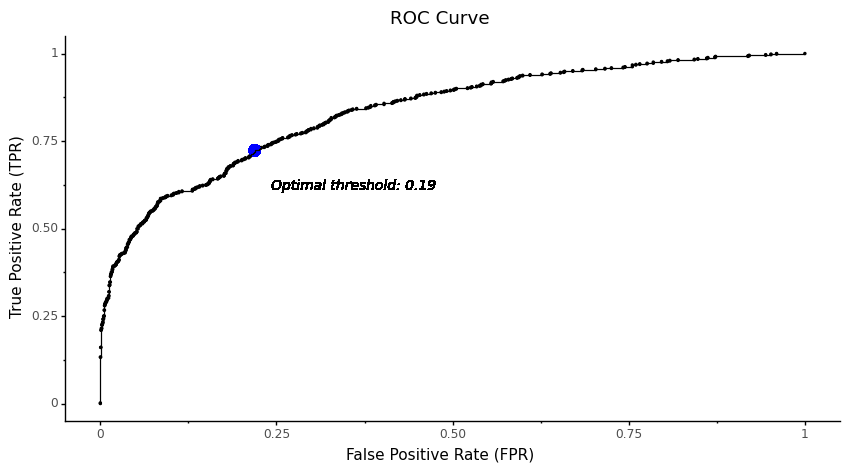

<ggplot: (8778462299971)>

In [102]:
# Create data viz
plotnine.options.figure_size = (10, 5)
(
    ggplot(data = roc_df)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = optimal_fpr,
                   y = optimal_tpr),
               color = 'blue',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = optimal_fpr,
                  y = optimal_tpr),
              label = 'Optimal threshold: {:.2f}'.format(optimal_threshold),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_classic()
)

#### Comment on model performance 

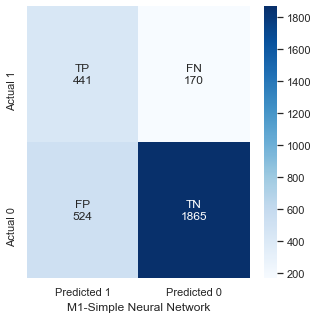

                 Model Name  Accuracy  Precision    Recall        F1
0  M1-Simple Neural Network  0.768667   0.456995  0.721768  0.559645


Model Name  Accuracy  Precision    Recall        F1
0  M1-Simple Neural Network  0.768667   0.456995  0.721768  0.559645

In [103]:
# Convert probabilities to classifications using the optimal threshold
y_class_predict = probability_to_classification(y_prob_predict, optimal_threshold)

# Create confusion matrix
cm = create_cm(y_test, y_class_predict, model_name)

# Compute the scores of this model
model_1_optimal_scores_df = calc_model_scores(cm, model_name)
model_1_optimal_scores_df

Observations:
* By using optimal threshold, the recall improves.  But the accuracy and precision went down.  However, this is expected and acceptable.

# Model Performance Improvement (15 Points)

## Can model performance be improved? check and comment
* I believe the model performance can be improved.  Model 1 is a very rudimentary fully-connected neural network, with 2 hidden layers and limited number of neurons.
* There are many things that can be done.  Some may improve the model, some may make it worse.
* Some of the things that can be done are:
> 1. Add more hidden layers
> 2. Add more neurons
> 3. Reduce the number of hidden layers
> 4. Reduct the number of neurons
> 5. Use early-stopping and initializing strategy
> 6. Use regularization technique
> 7. Use weighted loss for class imbalance


## Build another model to implement these improvements 

### Model 2 - SNN & More Hidden Layers
* This model is similar to the previous model (Simple Neural Network) except the number of hidden layers is increased.

In [104]:
# Create a Sequential model
model_2 = Sequential()
model_name = 'M2-SNN & More Hidden Layers'

In [105]:
# Add an input layer and the first hidden layer
model_2.add(Dense(units=24, input_dim=num_features, activation='relu'))

# Add more hidden layer
model_2.add(Dense(units=24, activation='relu'))

# Add more hidden layer
model_2.add(Dense(units=24, activation='relu'))

# Add more hidden layer
model_2.add(Dense(units=24, activation='relu'))

# Add the output layer
model_2.add(Dense(1, activation='sigmoid'))

In [106]:
# Compile the model with an optimizer and a loss function
model_2.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=[Recall()])

In [107]:
# Verify the model - it should be consistent with the added layers
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 24)                336       
_________________________________________________________________
dense_4 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_5 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_6 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 2,161
Trainable params: 2,161
Non-trainable params: 0
_________________________________________________________________


In [108]:
# Train the model with train data
history = model_2.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=VALIDATION_SPLIT, verbose=0)

Text(0.5, 0, 'M2-SNN & More Hidden Layers')

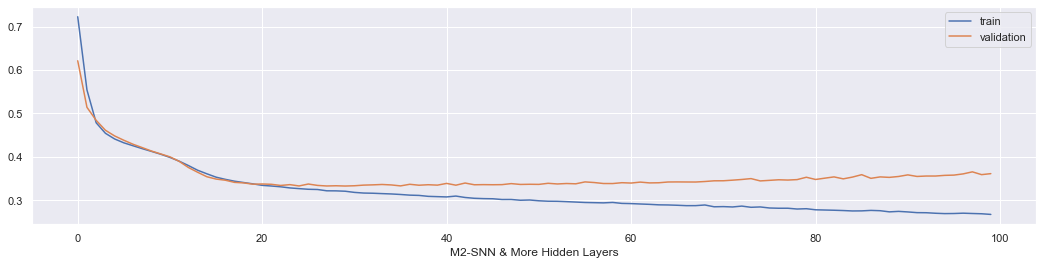

In [109]:
# Create a data frame for history to plot
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch

# Plot the loss of the model vs. epoch
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.legend(("train", "validation"), loc='best')
plt.xlabel(model_name)

In [110]:
# Evaluate the model against test data
score = model_2.evaluate(X_test, y_test)

94/94 [==============================] - 0s 498us/step - loss: 0.3940 - recall_1: 0.4714


#### Find the optimal threshold using ROC-AUC - Model 2

In [111]:
# Use the model to predict the probabilities
y_prob_predict = model_2.predict(X_test)

# Calculate AUC of ROC and various optimal metrics such as FPR, TPR, and threshold
roc_df, auc, optimal_fpr, optimal_tpr, optimal_threshold = calc_roc_data(y_test, y_prob_predict)

# Display optimal metrics
model_2_optimal_metrics_df = pd.DataFrame({'Model Name': [model_name], 'AUC': [auc], 'Optimal FPR': [optimal_fpr], 'Optimal TPR': [optimal_tpr], 'Optimal Threshold': [optimal_threshold]})
model_2_optimal_metrics_df

Model Name       AUC  Optimal FPR  Optimal TPR  \
0  M2-SNN & More Hidden Layers  0.826463       0.2281       0.7152   

   Optimal Threshold  
0             0.1543

In [112]:
# Create data viz
plotnine.options.figure_size = (10, 5)
(
    ggplot(data = roc_df)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = optimal_fpr,
                   y = optimal_tpr),
               color = 'blue',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = optimal_fpr,
                  y = optimal_tpr),
              label = 'Optimal threshold: {:.2f}'.format(optimal_threshold),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_classic()
)

<ggplot: (8778462722853)>

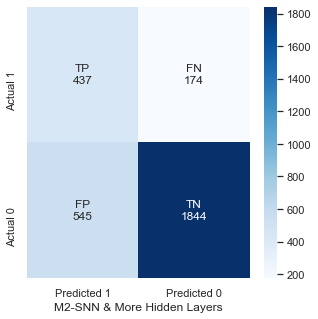

                    Model Name  Accuracy  Precision    Recall       F1
0  M2-SNN & More Hidden Layers  0.760333    0.44501  0.715221  0.54865


Model Name  Accuracy  Precision    Recall       F1
0  M2-SNN & More Hidden Layers  0.760333    0.44501  0.715221  0.54865

In [113]:
# Convert probabilities to classifications using the optimal threshold
y_class_predict = probability_to_classification(y_prob_predict, optimal_threshold)

# Create a confusion matrix
cm = create_cm(y_test, y_class_predict, model_name)

# Display optimal scores
model_2_optimal_scores_df = calc_model_scores(cm, model_name)
model_2_optimal_scores_df

#### Comment on model performance 
* Recall needs to be even higher.  There are still 133 false negatives and this is only based on test data.
* The validation curve goes up after about 20 epochs.
* The train curve continues to go down, diverging from the validation curve.  This indicates that the model overfit the train data.

### Model 3 - SNN & More Neurons
* This model is the same as Model 1, except more neurons are added to each hidden layer.



In [114]:
# Create a Sequential model
model_3 = Sequential()
model_name = 'M3-SNN & More Neurons'

In [115]:
# Add an input layer and the first hidden layer
model_3.add(Dense(units=48, input_dim=num_features, activation='relu'))

# Add more hidden layer
model_3.add(Dense(units=48, activation='relu'))

# Add the output layer
model_3.add(Dense(1, activation='sigmoid'))

In [116]:
# Compile the model with an optimizer and a loss function
model_3.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=[Recall()])

In [117]:
# Verify the model - it should be consistent with the added layers
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 48)                672       
_________________________________________________________________
dense_9 (Dense)              (None, 48)                2352      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 49        
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________


In [118]:
# Train the model with train data
history = model_3.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=VALIDATION_SPLIT, verbose=0)

Text(0.5, 0, 'M3-SNN & More Neurons')

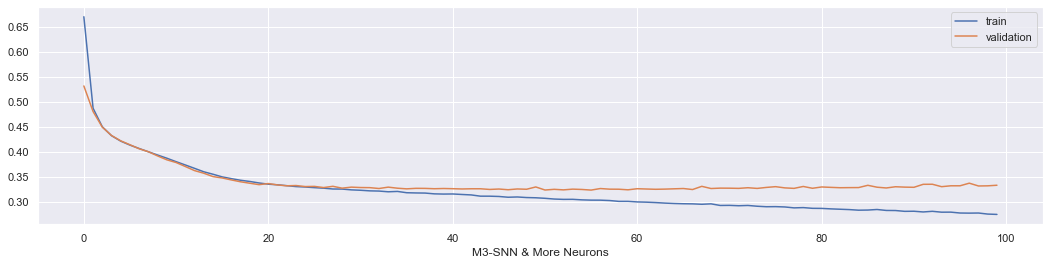

In [119]:
# Create a data frame for history to plot
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch

# Plot the loss of the model vs. epoch
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.legend(("train", "validation"), loc='best')
plt.xlabel(model_name)

In [120]:
# Evaluate the model against test data
score = model_3.evaluate(X_test, y_test)

94/94 [==============================] - 0s 581us/step - loss: 0.3662 - recall_2: 0.4943


#### Find the optimal threshold using ROC-AUC - Model 3

In [121]:
# Use the model to predict the probabilities
y_prob_predict = model_3.predict(X_test)

# Calculate AUC of ROC and various optimal metrics such as FPR, TPR, and threshold
roc_df, auc, optimal_fpr, optimal_tpr, optimal_threshold = calc_roc_data(y_test, y_prob_predict)

# Display optimal metrics
model_3_optimal_metrics_df = pd.DataFrame({'Model Name': [model_name], 'AUC': [auc], 'Optimal FPR': [optimal_fpr], 'Optimal TPR': [optimal_tpr], 'Optimal Threshold': [optimal_threshold]})
model_3_optimal_metrics_df

Model Name       AUC  Optimal FPR  Optimal TPR  \
0  M3-SNN & More Neurons  0.838329       0.2105       0.7283   

   Optimal Threshold  
0             0.1915

In [122]:
# Create data viz
plotnine.options.figure_size = (10, 5)
(
    ggplot(data = roc_df)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = optimal_fpr,
                   y = optimal_tpr),
               color = 'blue',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = optimal_fpr,
                  y = optimal_tpr),
              label = 'Optimal threshold: {:.2f}'.format(optimal_threshold),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_classic()
)

<ggplot: (8778512198632)>

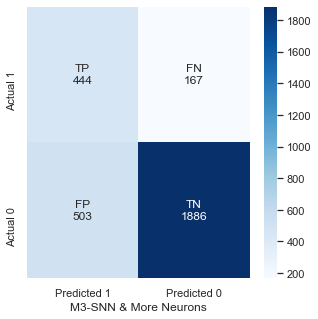

              Model Name  Accuracy  Precision    Recall        F1
0  M3-SNN & More Neurons  0.776667   0.468849  0.726678  0.569961


Model Name  Accuracy  Precision    Recall        F1
0  M3-SNN & More Neurons  0.776667   0.468849  0.726678  0.569961

In [123]:
# Convert probabilities to classifications using the optimal threshold
y_class_predict = probability_to_classification(y_prob_predict, optimal_threshold)

# Create a confusion matrix
cm = create_cm(y_test, y_class_predict, model_name)

# Display optimal scores
model_3_optimal_scores_df = calc_model_scores(cm, model_name)
model_3_optimal_scores_df

#### Comment on model performance 
* More neurons do not seem to positively change the results.  Recall is still lower than that of Model 1.
* Again validation and train curves diverge, indicating overfitting.

### Model 4 - SNN & Less Hidden Layers
* This model will use less hidden layers while having the same number of neurons at remaining hidden layer(s).

In [124]:
# Create a Sequential model
model_4 = Sequential()
model_name = 'M4-SNN & Less Hidden Layers'

In [125]:
# Add an input layer and the first hidden layer
model_4.add(Dense(units=24, input_dim=num_features, activation='relu'))

# Add the output layer
model_4.add(Dense(1, activation='sigmoid'))

In [126]:
# Compile the model with an optimizer and a loss function
model_4.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=[Recall()])

In [127]:
# Verify the model - it should be consistent with the added layers
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 24)                336       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 25        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [128]:
# Train the model with train data
history = model_4.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=VALIDATION_SPLIT, verbose=0)

Text(0.5, 0, 'M4-SNN & Less Hidden Layers')

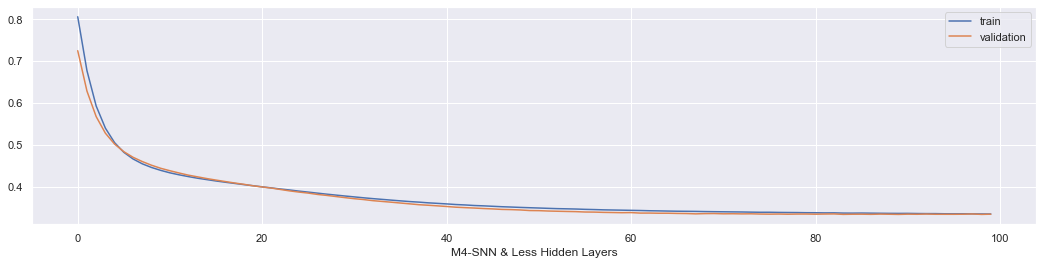

In [129]:
# Create a data frame for history to plot
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch

# Plot the loss of the model vs. epoch
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.legend(("train", "validation"), loc='best')
plt.xlabel(model_name)

In [130]:
# Evaluate the model against test data
score = model_4.evaluate(X_test, y_test)

94/94 [==============================] - 0s 549us/step - loss: 0.3635 - recall_3: 0.4534


#### Find the optimal threshold using ROC-AUC - Model 4

In [131]:
# Use the model to predict the probabilities
y_prob_predict = model_4.predict(X_test)

# Calculate AUC of ROC and various optimal metrics such as FPR, TPR, and threshold
roc_df, auc, optimal_fpr, optimal_tpr, optimal_threshold = calc_roc_data(y_test, y_prob_predict)

# Display optimal metrics
model_4_optimal_metrics_df = pd.DataFrame({'Model Name': [model_name], 'AUC': [auc], 'Optimal FPR': [optimal_fpr], 'Optimal TPR': [optimal_tpr], 'Optimal Threshold': [optimal_threshold]})
model_4_optimal_metrics_df

Model Name       AUC  Optimal FPR  Optimal TPR  \
0  M4-SNN & Less Hidden Layers  0.833433       0.2122       0.7201   

   Optimal Threshold  
0             0.2071

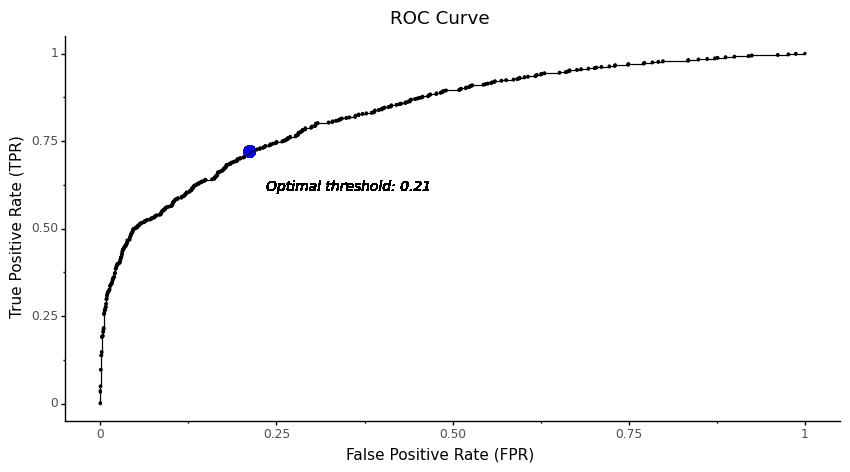

<ggplot: (8778528439420)>

In [132]:
# Create data viz
plotnine.options.figure_size = (10, 5)
(
    ggplot(data = roc_df)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = optimal_fpr,
                   y = optimal_tpr),
               color = 'blue',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = optimal_fpr,
                  y = optimal_tpr),
              label = 'Optimal threshold: {:.2f}'.format(optimal_threshold),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_classic()
)

In [133]:
# Convert probabilities to classifications using the optimal threshold
y_class_predict = probability_to_classification(y_prob_predict, optimal_threshold)

# Create a confusion matrix
cm = create_cm(y_test, y_class_predict, model_name)

# Display optimal scores
model_4_optimal_scores_df = calc_model_scores(cm, model_name)
model_4_optimal_scores_df

                    Model Name  Accuracy  Precision    Recall        F1
0  M4-SNN & Less Hidden Layers  0.773667   0.464059  0.718494  0.563905


Model Name  Accuracy  Precision    Recall        F1
0  M4-SNN & Less Hidden Layers  0.773667   0.464059  0.718494  0.563905

#### Comment on model performance 
* It's surprising that less hidden layer strategy yieds a better recall, compared to Model 1.
* Accuracy ad Precision continue to decline, but they're not as important as recall.
* The train and validation curves diverge less.  That means the model did not overfit as much.
* After 60 epochs, both curves hit steady-state.  No reason to train more epochs.
* It would be nice to improve from this model.

### Model 5 - SNN & Less Neurons
* This model uses the same number of hidden layers as M1, but with less neurons at each hidden layer.

In [134]:
# Create a Sequential model
model_5 = Sequential()
model_name = 'M5-SNN & Less Neurons'

In [135]:
# Add an input layer and the first hidden layer
model_5.add(Dense(units=18, input_dim=num_features, activation='relu'))

# Add more hidden layer
model_5.add(Dense(units=18, activation='relu'))

# Add the output layer
model_5.add(Dense(1, activation='sigmoid'))

In [136]:
# Compile the model with an optimizer and a loss function
model_5.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=[Recall()])

In [137]:
# Verify the model - it should be consistent with the added layers
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 18)                252       
_________________________________________________________________
dense_14 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 19        
Total params: 613
Trainable params: 613
Non-trainable params: 0
_________________________________________________________________


In [138]:
# Train the model with train data
history = model_5.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=VALIDATION_SPLIT, verbose=0)

In [139]:
# Create a data frame for history to plot
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch

# Plot the loss of the model vs. epoch
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.legend(("train", "validation"), loc='best')
plt.xlabel(model_name)

Text(0.5, 0, 'M5-SNN & Less Neurons')

In [140]:
# Evaluate the model against test data
score = model_5.evaluate(X_test, y_test)

94/94 [==============================] - 0s 586us/step - loss: 0.3540 - recall_4: 0.4763


#### Find the optimal threshold using ROC-AUC - Model 5

In [141]:
# Use the model to predict the probabilities
y_prob_predict = model_5.predict(X_test)

# Calculate AUC of ROC and various optimal metrics such as FPR, TPR, and threshold
roc_df, auc, optimal_fpr, optimal_tpr, optimal_threshold = calc_roc_data(y_test, y_prob_predict)

# Display optimal metrics
model_5_optimal_metrics_df = pd.DataFrame({'Model Name': [model_name], 'AUC': [auc], 'Optimal FPR': [optimal_fpr], 'Optimal TPR': [optimal_tpr], 'Optimal Threshold': [optimal_threshold]})
model_5_optimal_metrics_df

Model Name       AUC  Optimal FPR  Optimal TPR  \
0  M5-SNN & Less Neurons  0.843218       0.2558       0.7774   

   Optimal Threshold  
0             0.1583

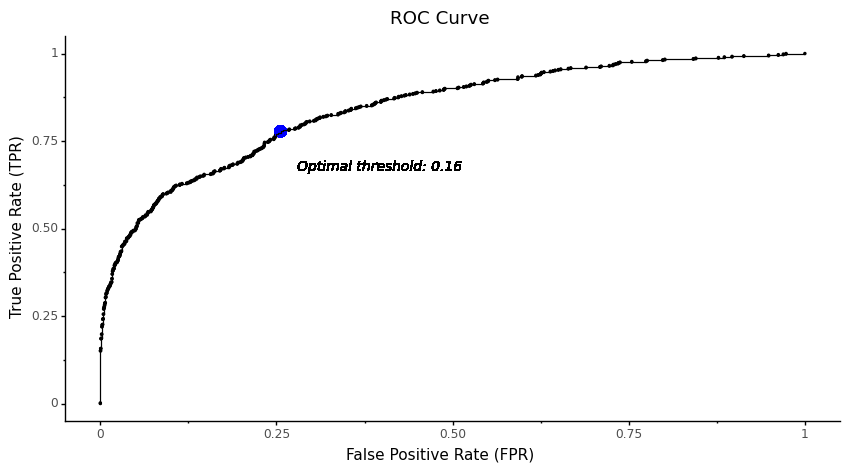

<ggplot: (8778528680846)>

In [142]:
# Create data viz
plotnine.options.figure_size = (10, 5)
(
    ggplot(data = roc_df)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = optimal_fpr,
                   y = optimal_tpr),
               color = 'blue',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = optimal_fpr,
                  y = optimal_tpr),
              label = 'Optimal threshold: {:.2f}'.format(optimal_threshold),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_classic()
)

In [143]:
# Convert probabilities to classifications using the optimal threshold
y_class_predict = probability_to_classification(y_prob_predict, optimal_threshold)

# Create a confusion matrix
cm = create_cm(y_test, y_class_predict, model_name)

# Display optimal scores
model_5_optimal_scores_df = calc_model_scores(cm, model_name)
model_5_optimal_scores_df

              Model Name  Accuracy  Precision    Recall        F1
0  M5-SNN & Less Neurons     0.751   0.437385  0.777414  0.559811


Model Name  Accuracy  Precision    Recall        F1
0  M5-SNN & Less Neurons     0.751   0.437385  0.777414  0.559811

#### Comment on model performance 
* Based on the AUC and recall, this is worse than Model 1.
* Having less neurons (compared to the number of neurons in Model 1) does not help.
* The curves also diverge.

### Model 6 - SNN & Early Stopping, Initialization
* This model is the same as Model 1 with the usage of Early Stopping and Initialization of hidden layers

In [144]:
# Create a Sequential model
model_6 = Sequential()
model_name = 'M6-SNN & Early Stopping, Initialization'

In [145]:
# Add an input layer and the first hidden layer
model_6.add(Dense(units=24, input_dim=num_features, kernel_initializer='he_normal', activation='relu'))

# Add more hidden layer
model_6.add(Dense(units=24, kernel_initializer='he_normal', activation='relu'))

# Add the output layer
model_6.add(Dense(1, activation='sigmoid'))

In [146]:
# Compile the model with an optimizer and a loss function
model_6.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=[Recall()])

In [147]:
# Verify the model - it should be consistent with the added layers
model_6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 24)                336       
_________________________________________________________________
dense_17 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 25        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [148]:
# Define Early Stopping strategy
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, mode='min', verbose=0, restore_best_weights=True)

# Train the model with train data
history = model_6.fit(X_train, y_train, batch_size=256, epochs=100, callbacks=[es], validation_split=VALIDATION_SPLIT, verbose=0)

In [149]:
# Create a data frame for history to plot
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch

# Plot the loss of the model vs. epoch
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.legend(("train", "validation"), loc='best')
plt.xlabel(model_name)

Text(0.5, 0, 'M6-SNN & Early Stopping, Initialization')

In [150]:
# Evaluate the model against test data
score = model_6.evaluate(X_test, y_test)

94/94 [==============================] - 0s 613us/step - loss: 0.3621 - recall_5: 0.4779


#### Find the optimal threshold using ROC-AUC - Model 6

In [151]:
# Use the model to predict the probabilities
y_prob_predict = model_6.predict(X_test)

# Calculate AUC of ROC and various optimal metrics such as FPR, TPR, and threshold
roc_df, auc, optimal_fpr, optimal_tpr, optimal_threshold = calc_roc_data(y_test, y_prob_predict)

# Display optimal metrics
model_6_optimal_metrics_df = pd.DataFrame({'Model Name': [model_name], 'AUC': [auc], 'Optimal FPR': [optimal_fpr], 'Optimal TPR': [optimal_tpr], 'Optimal Threshold': [optimal_threshold]})
model_6_optimal_metrics_df

Model Name       AUC  Optimal FPR  \
0  M6-SNN & Early Stopping, Initialization  0.839568        0.203   

   Optimal TPR  Optimal Threshold  
0       0.7267             0.2008

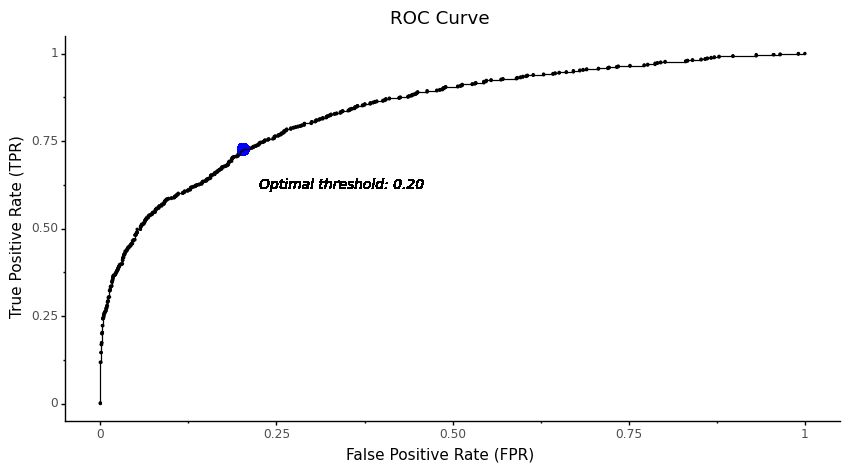

<ggplot: (8778478128571)>

In [152]:
# Create data viz
plotnine.options.figure_size = (10, 5)
(
    ggplot(data = roc_df)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = optimal_fpr,
                   y = optimal_tpr),
               color = 'blue',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = optimal_fpr,
                  y = optimal_tpr),
              label = 'Optimal threshold: {:.2f}'.format(optimal_threshold),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_classic()
)

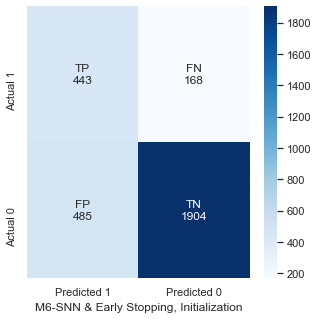

                                Model Name  Accuracy  Precision    Recall  \
0  M6-SNN & Early Stopping, Initialization  0.782333   0.477371  0.725041   

         F1  
0  0.575699  


Model Name  Accuracy  Precision    Recall  \
0  M6-SNN & Early Stopping, Initialization  0.782333   0.477371  0.725041   

         F1  
0  0.575699

In [153]:
# Convert probabilities to classifications using the optimal threshold
y_class_predict = probability_to_classification(y_prob_predict, optimal_threshold)

# Create a confusion matrix
cm = create_cm(y_test, y_class_predict, model_name)

# Display optimal scores
model_6_optimal_scores_df = calc_model_scores(cm, model_name)
model_6_optimal_scores_df

#### Comment on model performance 
* Recall is the same as that of Model 1, even though AUC is worse.
* There is also divergence between validation and train curves.
* Early stop strategy doesn't help.  If the curves (train and validation) drop significantly and then go up, then early stopping would help.  But not with the curves produced by this Model 6.

### Model 7 - SNN & Regularization
* To prevent overfitting, this model will use regularization technique for DNN.  Model 1 is still used as the basis to build this model.

In [154]:
# Create a Sequential model
model_7 = Sequential()
model_name = 'M7-SNN & Regularization'

In [155]:
# Add an input layer and the first hidden layer
model_7.add(Dense(units=24, input_dim=num_features, activation='relu'))

# Add regularization
model_7.add(Dropout(0.5))

# Add more hidden layer
model_7.add(Dense(units=24, activation='relu'))

# Add regularization
model_7.add(Dropout(0.5))

# Add the output layer
model_7.add(Dense(1, activation='sigmoid'))

In [156]:
# Compile the model with an optimizer and a loss function
model_7.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=[Recall()])

In [157]:
# Verify the model - it should be consistent with the added layers
model_7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 24)                336       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 24)                600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 25        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [158]:
# Train the model with train data
history = model_7.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=VALIDATION_SPLIT, verbose=0)

In [159]:
# Create a data frame for history to plot
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch

# Plot the loss of the model vs. epoch
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.legend(("train", "validation"), loc='best')
plt.xlabel(model_name)

Text(0.5, 0, 'M7-SNN & Regularization')

In [160]:
# Evaluate the model against test data
score = model_7.evaluate(X_test, y_test)

94/94 [==============================] - 0s 610us/step - loss: 0.3728 - recall_6: 0.3453


#### Find the optimal threshold using ROC-AUC - Model 7

In [161]:
# Use the model to predict the probabilities
y_prob_predict = model_7.predict(X_test)

# Calculate AUC of ROC and various optimal metrics such as FPR, TPR, and threshold
roc_df, auc, optimal_fpr, optimal_tpr, optimal_threshold = calc_roc_data(y_test, y_prob_predict)

# Display optimal metrics
model_7_optimal_metrics_df = pd.DataFrame({'Model Name': [model_name], 'AUC': [auc], 'Optimal FPR': [optimal_fpr], 'Optimal TPR': [optimal_tpr], 'Optimal Threshold': [optimal_threshold]})
model_7_optimal_metrics_df

Model Name       AUC  Optimal FPR  Optimal TPR  \
0  M7-SNN & Regularization  0.828858        0.185       0.6989   

   Optimal Threshold  
0             0.2353

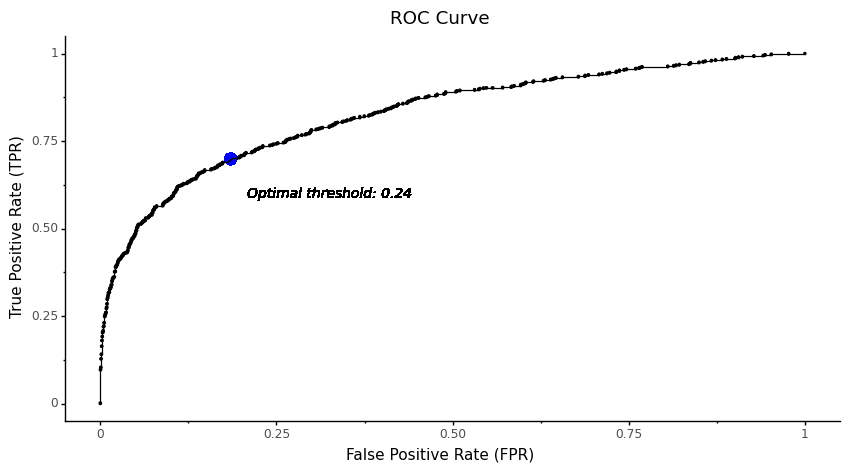

<ggplot: (8778470261664)>

In [162]:
# Create data viz
plotnine.options.figure_size = (10, 5)
(
    ggplot(data = roc_df)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = optimal_fpr,
                   y = optimal_tpr),
               color = 'blue',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = optimal_fpr,
                  y = optimal_tpr),
              label = 'Optimal threshold: {:.2f}'.format(optimal_threshold),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_classic()
)

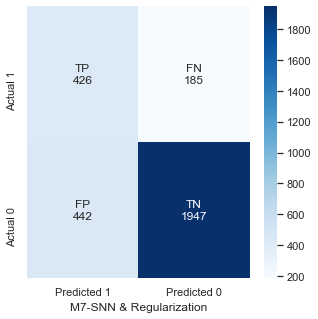

                Model Name  Accuracy  Precision    Recall        F1
0  M7-SNN & Regularization     0.791   0.490783  0.697218  0.576065


Model Name  Accuracy  Precision    Recall        F1
0  M7-SNN & Regularization     0.791   0.490783  0.697218  0.576065

In [163]:
# Convert probabilities to classifications using the optimal threshold
y_class_predict = probability_to_classification(y_prob_predict, optimal_threshold)

# Create a confusion matrix
cm = create_cm(y_test, y_class_predict, model_name)

# Display optimal scores
model_7_optimal_scores_df = calc_model_scores(cm, model_name)
model_7_optimal_scores_df
model_7_optimal_scores_df

#### Comment on model performance 
* Comparing Model 1's graph and that of Model 7, regularization does show promise in overfitting reduction
* It's surprising that the validation curve has more error loss than the training one.  Perhaps, this means the observations in the train data are "further apart" than those in validation.
* However, recall score is still worse than that of Model 1.

### Model 8 - Regularization & Class Weights
* The dataset used in this analysis has 4:1 ratio (more class 0 than class 1).  This indicates data imbalance.  Class weights are supposed to help improve that.  Model 8 will utilize this strategy.

In [164]:
# Create a Sequential model
model_8 = Sequential()
model_name = 'M8-SNN & Class Weights'

In [165]:
# Add an input layer and the first hidden layer
model_8.add(Dense(units=256, input_shape=(num_features, ), activation='relu'))

# Apply regularization technique
model_8.add(Dropout(0.05))

# Add more hidden layer
model_8.add(Dense(units=256, activation='relu'))

# Add more hidden layer
model_8.add(Dense(units=256, activation='relu'))

# Add more hidden layer
model_8.add(Dense(units=256, activation='relu'))

# Add the output layer
model_8.add(Dense(1, activation='sigmoid'))

In [166]:
# Compile the model with an optimizer and a loss function
model_8.compile(optimizer=Adam(learning_rate=0.00001), loss=BinaryCrossentropy(), metrics=[Recall()])

In [167]:
# Verify the model - it should be consistent with the added layers
model_8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 256)               3584      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 257       
Total params: 201,217
Trainable params: 201,217
Non-trainable params: 0
________________________________________________

In [168]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), np.array([y_train.iloc[i] for i in range(len(y_train))]))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6279153211338356, 1: 2.4544179523141656}

In [169]:
# Train the model with train data
history = model_8.fit(X_train, y_train, batch_size=256, epochs=100, class_weight=class_weights, validation_split=VALIDATION_SPLIT, verbose=0)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [170]:
# Create a data frame for history to plot
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch

# Plot the loss of the model vs. epoch
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.legend(("train", "validation"), loc='best')
plt.xlabel(model_name)

Text(0.5, 0, 'M8-SNN & Class Weights')

In [171]:
# Evaluate the model against test data
score = model_8.evaluate(X_test, y_test)

94/94 [==============================] - 0s 792us/step - loss: 0.4817 - recall_7: 0.7152


#### Find the optimal threshold using ROC-AUC - Model 8

In [172]:
# Use the model to predict the probabilities
y_prob_predict = model_8.predict(X_test)

# Calculate AUC of ROC and various optimal metrics such as FPR, TPR, and threshold
roc_df, auc, optimal_fpr, optimal_tpr, optimal_threshold = calc_roc_data(y_test, y_prob_predict)

# Display optimal metrics
model_8_optimal_metrics_df = pd.DataFrame({'Model Name': [model_name], 'AUC': [auc], 'Optimal FPR': [optimal_fpr], 'Optimal TPR': [optimal_tpr], 'Optimal Threshold': [optimal_threshold]})
model_8_optimal_metrics_df

Model Name       AUC  Optimal FPR  Optimal TPR  \
0  M8-SNN & Class Weights  0.823992        0.211       0.7152   

   Optimal Threshold  
0             0.5071

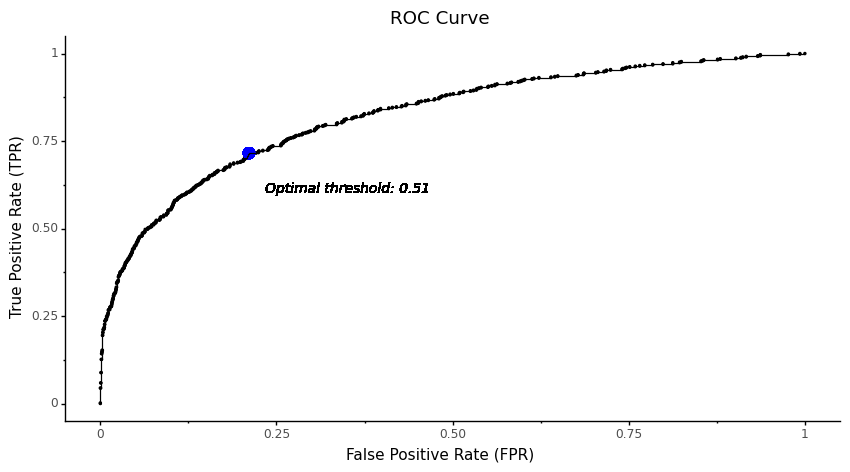

<ggplot: (8778478065737)>

In [173]:
# Create data viz
plotnine.options.figure_size = (10, 5)
(
    ggplot(data = roc_df)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = optimal_fpr,
                   y = optimal_tpr),
               color = 'blue',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = optimal_fpr,
                  y = optimal_tpr),
              label = 'Optimal threshold: {:.2f}'.format(optimal_threshold),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_classic()
)

In [174]:
# Convert probabilities to classifications using the optimal threshold
y_class_predict = probability_to_classification(y_prob_predict, optimal_threshold)

# Create a confusion matrix
cm = create_cm(y_test, y_class_predict, model_name)

# Display optimal scores
model_8_optimal_scores_df = calc_model_scores(cm, model_name)
model_8_optimal_scores_df
model_8_optimal_scores_df

               Model Name  Accuracy  Precision    Recall        F1
0  M8-SNN & Class Weights  0.773667    0.46383  0.713584  0.562218


Model Name  Accuracy  Precision    Recall        F1
0  M8-SNN & Class Weights  0.773667    0.46383  0.713584  0.562218

#### Comment on model performance 
* Surprisingly, Model 8 did not produce the best recall.

## Include all the model which were trained to reach at the final one

In [175]:
comparison_optimal_scores_df = model_1_optimal_scores_df.copy()
comparison_optimal_scores_df = comparison_optimal_scores_df.append(model_2_optimal_scores_df, ignore_index=True)
comparison_optimal_scores_df = comparison_optimal_scores_df.append(model_3_optimal_scores_df, ignore_index=True)
comparison_optimal_scores_df = comparison_optimal_scores_df.append(model_4_optimal_scores_df, ignore_index=True)
comparison_optimal_scores_df = comparison_optimal_scores_df.append(model_5_optimal_scores_df, ignore_index=True)
comparison_optimal_scores_df = comparison_optimal_scores_df.append(model_6_optimal_scores_df, ignore_index=True)
comparison_optimal_scores_df = comparison_optimal_scores_df.append(model_7_optimal_scores_df, ignore_index=True)
comparison_optimal_scores_df = comparison_optimal_scores_df.append(model_8_optimal_scores_df, ignore_index=True)
comparison_optimal_scores_df

Model Name  Accuracy  Precision    Recall  \
0                 M1-Simple Neural Network  0.768667   0.456995  0.721768   
1              M2-SNN & More Hidden Layers  0.760333   0.445010  0.715221   
2                    M3-SNN & More Neurons  0.776667   0.468849  0.726678   
3              M4-SNN & Less Hidden Layers  0.773667   0.464059  0.718494   
4                    M5-SNN & Less Neurons  0.751000   0.437385  0.777414   
5  M6-SNN & Early Stopping, Initialization  0.782333   0.477371  0.725041   
6                  M7-SNN & Regularization  0.791000   0.490783  0.697218   
7                   M8-SNN & Class Weights  0.773667   0.463830  0.713584   

         F1  
0  0.559645  
1  0.548650  
2  0.569961  
3  0.563905  
4  0.559811  
5  0.575699  
6  0.576065  
7  0.562218

In [176]:
comparison_optimal_metrics_df = model_1_optimal_metrics_df.copy()
comparison_optimal_metrics_df = comparison_optimal_metrics_df.append(model_2_optimal_metrics_df, ignore_index=True)
comparison_optimal_metrics_df = comparison_optimal_metrics_df.append(model_3_optimal_metrics_df, ignore_index=True)
comparison_optimal_metrics_df = comparison_optimal_metrics_df.append(model_4_optimal_metrics_df, ignore_index=True)
comparison_optimal_metrics_df = comparison_optimal_metrics_df.append(model_5_optimal_metrics_df, ignore_index=True)
comparison_optimal_metrics_df = comparison_optimal_metrics_df.append(model_6_optimal_metrics_df, ignore_index=True)
comparison_optimal_metrics_df = comparison_optimal_metrics_df.append(model_7_optimal_metrics_df, ignore_index=True)
comparison_optimal_metrics_df = comparison_optimal_metrics_df.append(model_8_optimal_metrics_df, ignore_index=True)
comparison_optimal_metrics_df

Model Name       AUC  Optimal FPR  \
0                 M1-Simple Neural Network  0.835893       0.2193   
1              M2-SNN & More Hidden Layers  0.826463       0.2281   
2                    M3-SNN & More Neurons  0.838329       0.2105   
3              M4-SNN & Less Hidden Layers  0.833433       0.2122   
4                    M5-SNN & Less Neurons  0.843218       0.2558   
5  M6-SNN & Early Stopping, Initialization  0.839568       0.2030   
6                  M7-SNN & Regularization  0.828858       0.1850   
7                   M8-SNN & Class Weights  0.823992       0.2110   

   Optimal TPR  Optimal Threshold  
0       0.7234             0.1898  
1       0.7152             0.1543  
2       0.7283             0.1915  
3       0.7201             0.2071  
4       0.7774             0.1583  
5       0.7267             0.2008  
6       0.6989             0.2353  
7       0.7152             0.5071

In [177]:
eval_df = comparison_optimal_scores_df.set_index('Model Name').join(comparison_optimal_metrics_df.set_index('Model Name'))
eval_df

Accuracy  Precision    Recall  \
Model Name                                                               
M1-Simple Neural Network                 0.768667   0.456995  0.721768   
M2-SNN & More Hidden Layers              0.760333   0.445010  0.715221   
M3-SNN & More Neurons                    0.776667   0.468849  0.726678   
M4-SNN & Less Hidden Layers              0.773667   0.464059  0.718494   
M5-SNN & Less Neurons                    0.751000   0.437385  0.777414   
M6-SNN & Early Stopping, Initialization  0.782333   0.477371  0.725041   
M7-SNN & Regularization                  0.791000   0.490783  0.697218   
M8-SNN & Class Weights                   0.773667   0.463830  0.713584   

                                               F1       AUC  Optimal FPR  \
Model Name                                                                 
M1-Simple Neural Network                 0.559645  0.835893       0.2193   
M2-SNN & More Hidden Layers              0.548650  0.826463       0.2281   
M3-SNN & More Neurons                    0.569961  0.838329       0.2105   
M4-SNN & Less Hidden Layers              0.563905  0.833433       0.2122   
M5-SNN & Less Neurons                    0.559811  0.843218       0.2558   
M6-SNN & Early Stopping, Initialization  0.575699  0.839568       0.2030   
M7-SNN & Regularization                  0.576065  0.828858       0.1850   
M8-SNN & Class Weights                   0.562218  0.823992       0.2110   

                                         Optimal TPR  Optimal Threshold  
Model Name                                                               
M1-Simple Neural Network                      0.7234             0.1898  
M2-SNN & More Hidden Layers                   0.7152             0.1543  
M3-SNN & More Neurons                         0.7283             0.1915  
M4-SNN & Less Hidden Layers                   0.7201             0.2071  
M5-SNN & Less Neurons                         0.7774             0.1583  
M6-SNN & Early Stopping, Initialization       0.7267             0.2008  
M7-SNN & Regularization                       0.6989             0.2353  
M8-SNN & Class Weights                        0.7152             0.5071

# Model Performance Evaluation (5 Points)


## Evaluate the model on different performance metrics and comment on the performance and scope of improvement
* The AUC score was computed for each of the models above.  A model with larger AUC score (as close to 1 as possible) is generally a better model.  Larger AUC score may imply that TPR increases while FPR may hold still or increase very little.  This translates to a better recall rate.
* From the table above, the model M5-SNN & Less Neurons has the largest AUC.  This model also shows that it has the largest recall rate (0.77).  I would select this model even though its F1 score is not as high as others and its precision is among the lowest.  As stated above, the goal of the analysis is to prevent customers from leaving.  So recall is the focus for improvement.  Therefore, I was willing to sacrifice the loss on accuracy, precision, and F1 scores.
* In terms of the scope of improvement, I was disappointed.  The first model M1 was a very simple model.  It was able provide 0.72 as recall.  After building 7 other models, M5 was selected, but the improvement was only 0.05.



# Conclusion and key takeaways (2.5 Points)


## Final conclusion about the analysis
* A big challenge is that there are so many parameters that can be tweaked.  And it's hard to know if one is on the right or wrong path.  Changing one parameter may lead to worse result, but perhaps change that parameter in conjunction with another may lead to better result.
* It would be good to use some kind of grid searh algorithm to find optimal set of hyperparameters.
* One frustrating thing about building DNN is that the performance metrics can change from one run after another, using the exact same data and without changing any code due to randomness.  Therefore, it was difficult to analyze and make conclusion.  One way to get around this issue is to use the same seed for random generating algorithms.



# Notebook overall (2.5 Points)
## Structure and flow - Well commented code